# Movies recomendation system

## Relevant packages

In [1]:
import numpy as np
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset overview

- Rating file :
       
    - `UserIDs` range between 1 and 6040

    - `MoviesIDs` range between 1 and 3952

    - `Ratings` are made on a 5-star scale (whole-star rating only)

    - `Timestamp` 

    - each user has at least 20 ratings

- Users file description :

    - UserID

    - Gender is denoted by `M` for male and `F` for female

    - Age is chosen from the following ranges :
                   
     - `1` : Under 18

     - `18` : 18-24

     - `25` : 25-34

     - `35` : 35-44

     - `45` : 45-49

     - `50` : 50-55

     - `56` : +56

    - `Zip-code` 

    - Occupation is chosen from the following choices : 

        - `0` : other or not specified

        - `1` : academic/educator

        - `2` : artist

        - `3` : clerical/admin

        - `4` : college/grad student

        - `5` : customer service

        - `6` : doctor/health care

        - `7` : executive/managerial

        - `8` : farmer

        - `9` : homemaker

        - `10` : K-12 student

        - `11` : lawyer

        - `12` : programmer

        - `13` : retired 

        - `14` : scales/marketing 

        - `15` : scientist

        - `16` : self-employed

        - `17` : technicien/engineer

        - `18` : tradsman/craftsman 

        - `19` : unemployed 

        - `20` : writer 

- Movies file description : 

  - `MovieID` : containe the movie id

  - `Title` : titles are identical to titles provided by the IMDB ( including year of release)

  - `Genres` : are pip-separated and are selected from the following genres : 

    - `Action`

    - `Adventure`

    - `Animation`

    - `Children's`

    - `Comedy`

    - `Drama`

    - `Fantasy`

    - `Film-Noir` 

    - `Horror`

    - `Musical` 

    - `Mystery` 

    - `Romance` 

    - `Sci-Fi`

    - `Thriller`

    - `War`

    - `Western`     
  

**Notes**:

  - Some MovieIDs do not correspond to a movie due to accidental duplicate entries and/or test entries

  - Movies are mostly entered by hand, so errors and inconsistences may exist

## Pre-processing

### Import dataset 

In [2]:
PATH = '../ml-1m/ml-1m/'

In [3]:
rating_df = pd.read_csv(
    f'{PATH}ratings.dat',
    sep= '::',
    header=None,
    engine = 'python',
    names = [
        'UserIDs',
        'MoviesIDs',
        'Ratings',
        'Timestamp'
        ],
    encoding = 'latin1'    
)

In [4]:
users_df = pd.read_csv(
    f'{PATH}users.dat',
    sep= '::',
    header=None,
    engine = 'python',
    names = [
        'UserID',
        'Gender',
        'Age',
        'Occupation',
        'Zip-code'
        ],
    encoding = 'latin1'    
)

In [5]:
movies_df = pd.read_csv(
    f'{PATH}movies.dat',
    sep= '::',
    header=None,
    engine = 'python',
    names = [
        'MovieID',
        'Title',
        'Genrs',
        ],
    encoding = 'latin1'    
)

In [6]:
users_df.head(2)
users_df.shape

(6040, 5)

In [52]:
movies_df.head(2)


,MovieID,Title,Genrs,YearOfRelease
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995


In [8]:
rating_df.head(2)


,UserIDs,MoviesIDs,Ratings,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109


In [9]:
rating_df.shape

(1000209, 4)

#### Check false ratings rows based on the existence of the userID and movieID in users table and movies table

In [10]:
valid_user_ids = set(users_df['UserID'])
valid_movie_ids = set(movies_df['MovieID'])


rating_df = rating_df[
    rating_df['UserIDs'].isin(valid_user_ids) &
    rating_df['MoviesIDs'].isin(valid_movie_ids)
]
rating_df.shape

(1000209, 4)

#### Divide zip-code based on region

In [11]:
def get_zone(zip_code):
    first_digit = int(zip_code[0])
    if first_digit in [8, 9]:
        return "West"
    elif first_digit == 7:
        return "Southwest"
    elif first_digit in [4, 5, 6]:
        return "Midwest"
    elif first_digit == 3:
        return "Southeast"
    elif first_digit in [0, 1, 2]:
        return "Northeast"
    else:
        return "Unknown" 

In [12]:
users_df['zone'] = users_df['Zip-code'].apply(get_zone)
users_df.head(4)

,UserID,Gender,Age,Occupation,Zip-code,zone
0,1,F,1,10,48067,Midwest
1,2,M,56,16,70072,Southwest
2,3,M,25,15,55117,Midwest
3,4,M,45,7,02460,Northeast


In [13]:
zones =users_df['zone'].value_counts()
zones

zone
West         1774
Northeast    1765
Midwest      1696
Southwest     419
Southeast     386
Name: count, dtype: int64

<Axes: xlabel='zone', ylabel='count'>

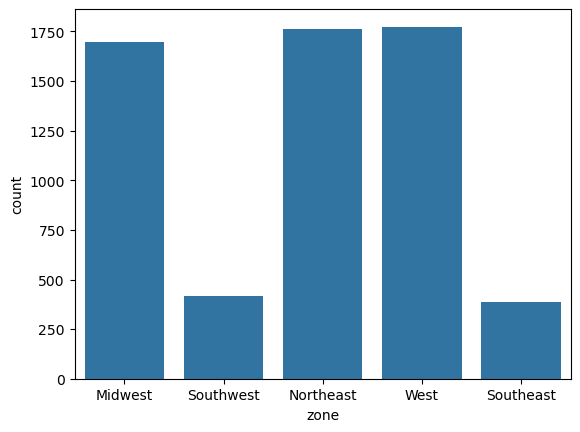

In [14]:
sns.countplot(
   data=users_df,
   x= 'zone'
)

#### Add realease year featrue

In [15]:
movies_df['YearOfRelease'] = movies_df['Title'].str.extract(r'\((\d{4})\)', expand=False)
movies_df.head(2)

,MovieID,Title,Genrs,YearOfRelease
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995


In [16]:
movies_df.isna().sum()

MovieID          0
Title            0
Genrs            0
YearOfRelease    0
dtype: int64

# EDA (Explatory Analysis)

## Gender analysis

### Gender distribution

In [17]:
palette = {'M':'blue','F':'red'} 

<Axes: xlabel='Gender', ylabel='count'>

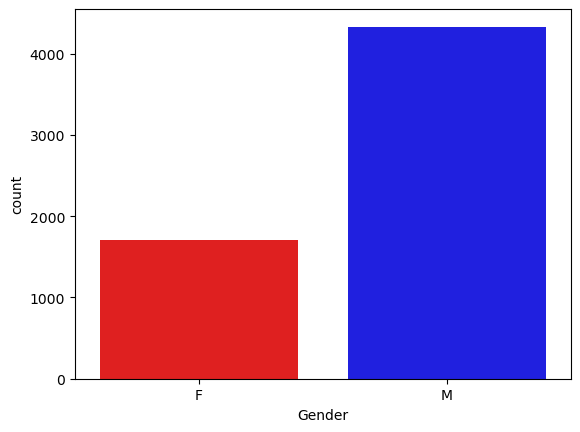

In [18]:
sns.countplot(x='Gender',hue='Gender',legend=False,data=users_df,palette=palette)

### Gender by Age 

<Axes: xlabel='Age', ylabel='count'>

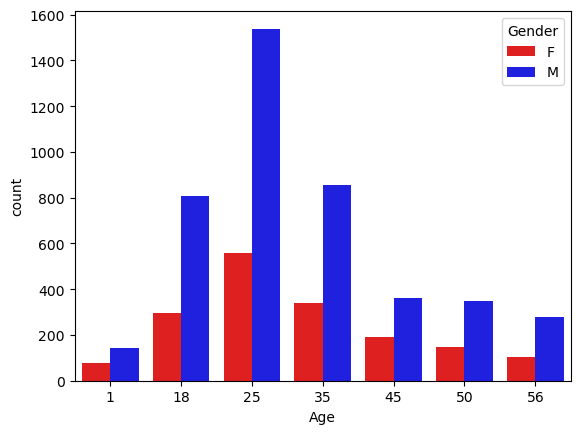

In [19]:
sns.countplot(hue='Gender',x='Age',data=users_df,palette=palette)

### Rating mean of each gender

In [20]:
occupation_map = {
    0: "other or not specified",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}

In [21]:
# Concate users_df with rating_df to get each user rating

users_mapped_occupation = users_df
users_mapped_occupation['Occupation'] = users_mapped_occupation['Occupation'].map(occupation_map)

rating_users_inter = pd.merge(users_mapped_occupation,rating_df,left_on='UserID',right_on='UserIDs')
rating_users_inter

,UserID,Gender,Age,Occupation,Zip-code,zone,UserIDs,MoviesIDs,Ratings,Timestamp
0,1,F,1,K-12 student,48067,Midwest,1,1193,5,978300760
1,1,F,1,K-12 student,48067,Midwest,1,661,3,978302109
2,1,F,1,K-12 student,48067,Midwest,1,914,3,978301968
3,1,F,1,K-12 student,48067,Midwest,1,3408,4,978300275
4,1,F,1,K-12 student,48067,Midwest,1,2355,5,978824291
...,...,...,...,...,...,...,...,...,...,...
1000204,6040,M,25,doctor/health care,11106,Northeast,6040,1091,1,956716541
1000205,6040,M,25,doctor/health care,11106,Northeast,6040,1094,5,956704887
1000206,6040,M,25,doctor/health care,11106,Northeast,6040,562,5,956704746
1000207,6040,M,25,doctor/health care,11106,Northeast,6040,1096,4,956715648


C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_25444\12200023.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Ratings',x='Gender',data=rating_users_inter,palette=palette)


<Axes: xlabel='Gender', ylabel='Ratings'>

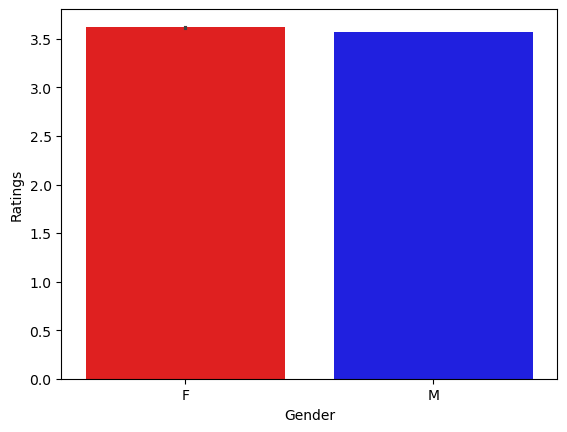

In [22]:
sns.barplot(y='Ratings',x='Gender',data=rating_users_inter,palette=palette)

### favorit movies genres for each gender

In [23]:
full_table = pd.merge(rating_users_inter,movies_df,left_on='MoviesIDs',right_on='MovieID')

In [24]:
favorite_table = full_table
favorite_table.head(4)

,UserID,Gender,Age,Occupation,Zip-code,zone,UserIDs,MoviesIDs,Ratings,Timestamp,MovieID,Title,Genrs,YearOfRelease
0,1,F,1,K-12 student,48067,Midwest,1,1193,5,978300760,1193,One Flew Over the Cuckoo's Nest (1975),Drama,1975
1,1,F,1,K-12 student,48067,Midwest,1,661,3,978302109,661,James and the Giant Peach (1996),Animation|Children's|Musical,1996
2,1,F,1,K-12 student,48067,Midwest,1,914,3,978301968,914,My Fair Lady (1964),Musical|Romance,1964
3,1,F,1,K-12 student,48067,Midwest,1,3408,4,978300275,3408,Erin Brockovich (2000),Drama,2000


**Note**: 
  - We see that our genres column may containe one or more values so we will explode this values

In [25]:
favorite_table['Genrs'] = favorite_table['Genrs'].str.split('|')
favorite_table_exploded = favorite_table.explode('Genrs')

C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_25444\367158863.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


<Axes: xlabel='Genrs', ylabel='count'>

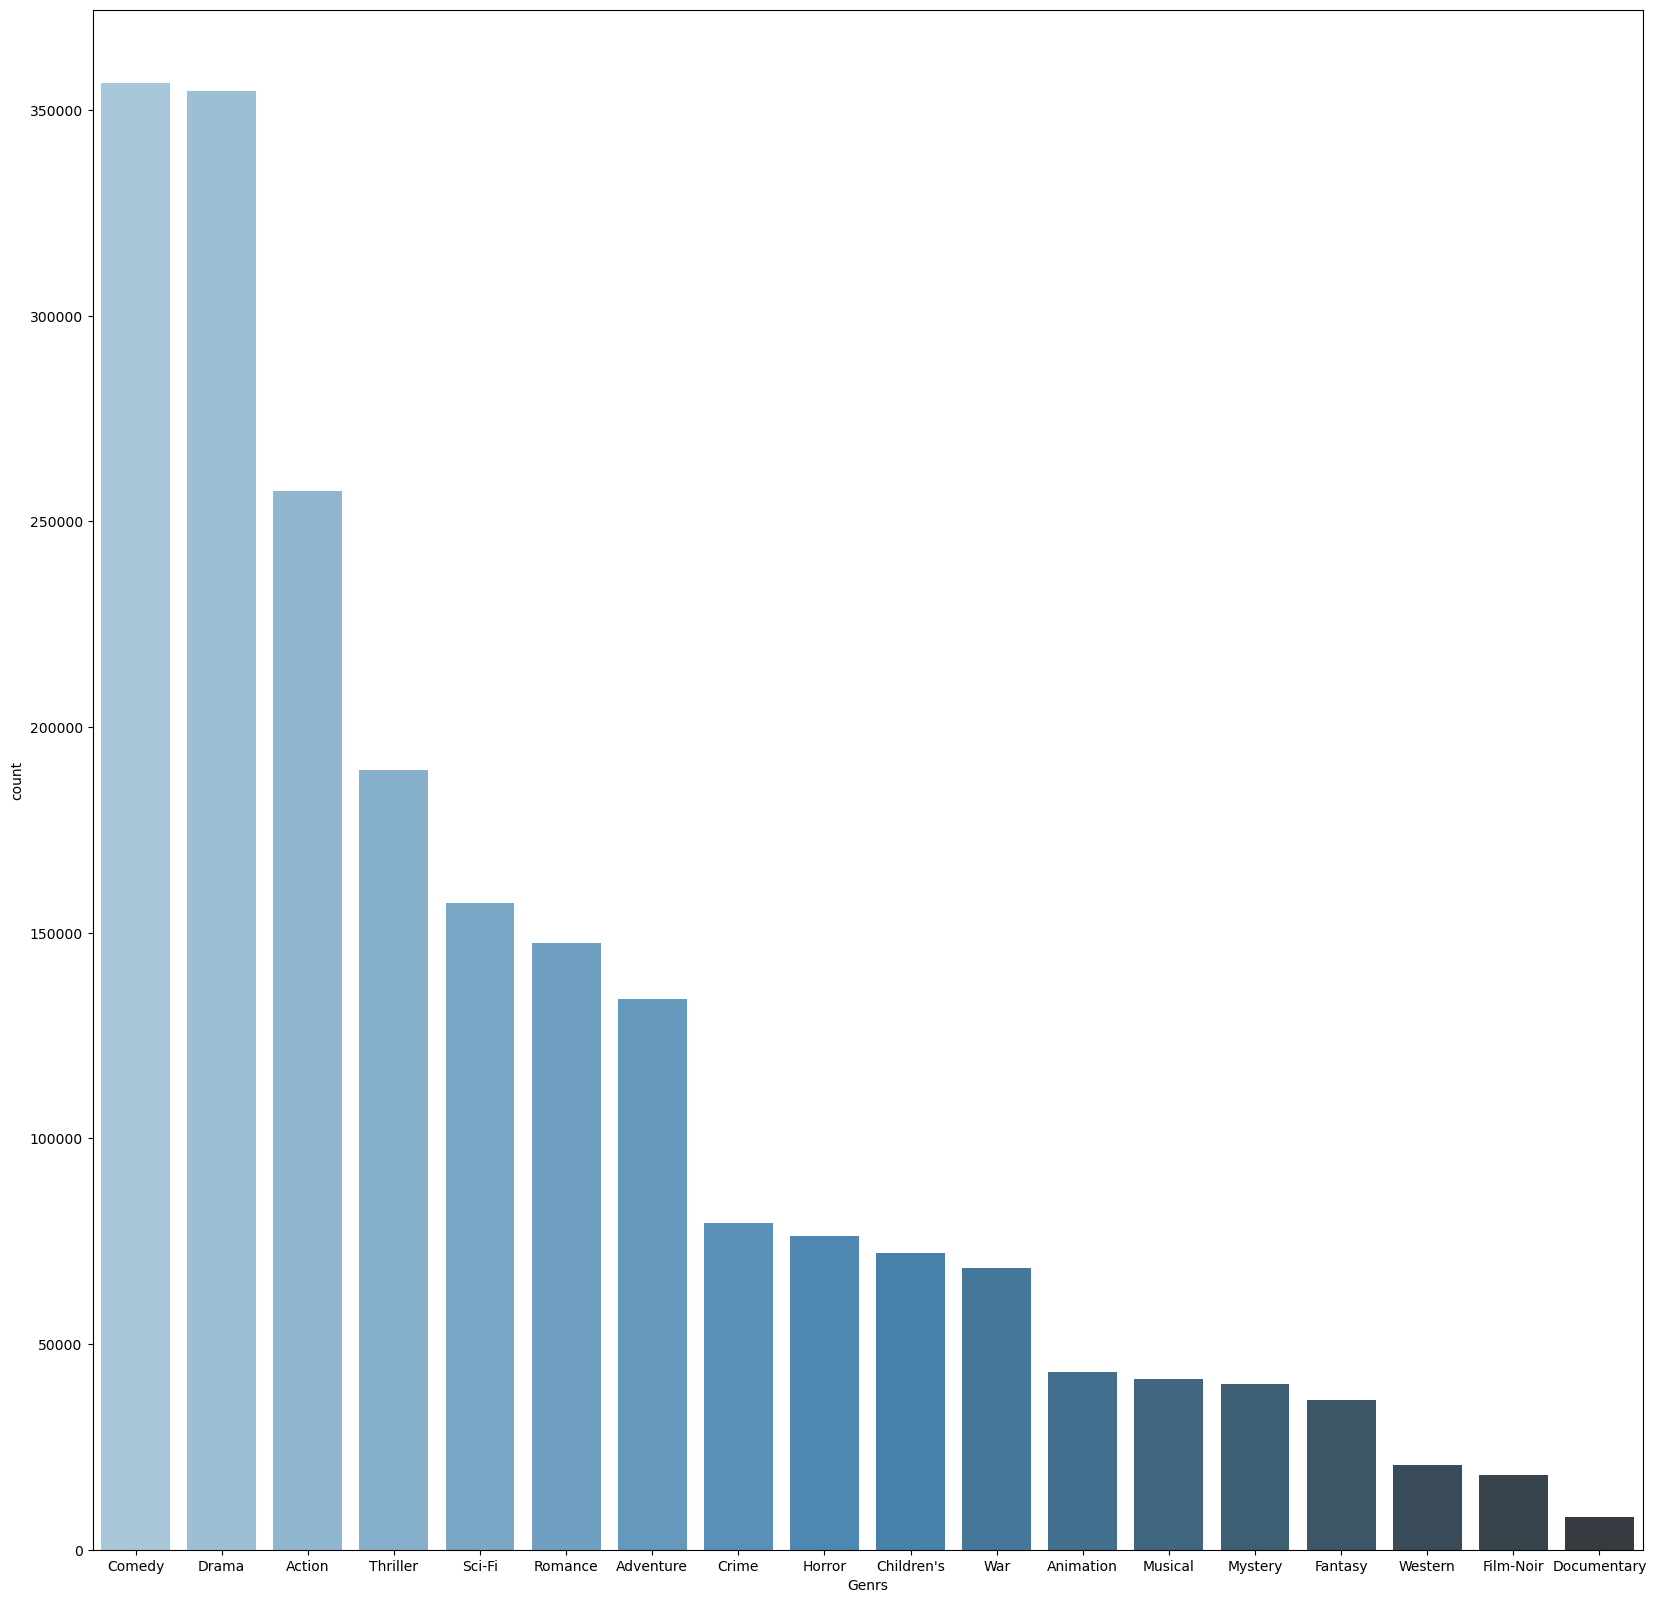

In [26]:
plt.figure(figsize=(20, 20))
sns.countplot(
    x='Genrs',
    data=favorite_table_exploded,
    palette='Blues_d',
    order=favorite_table_exploded['Genrs'].value_counts().index
    )

<Axes: xlabel='Genrs', ylabel='Ratings'>

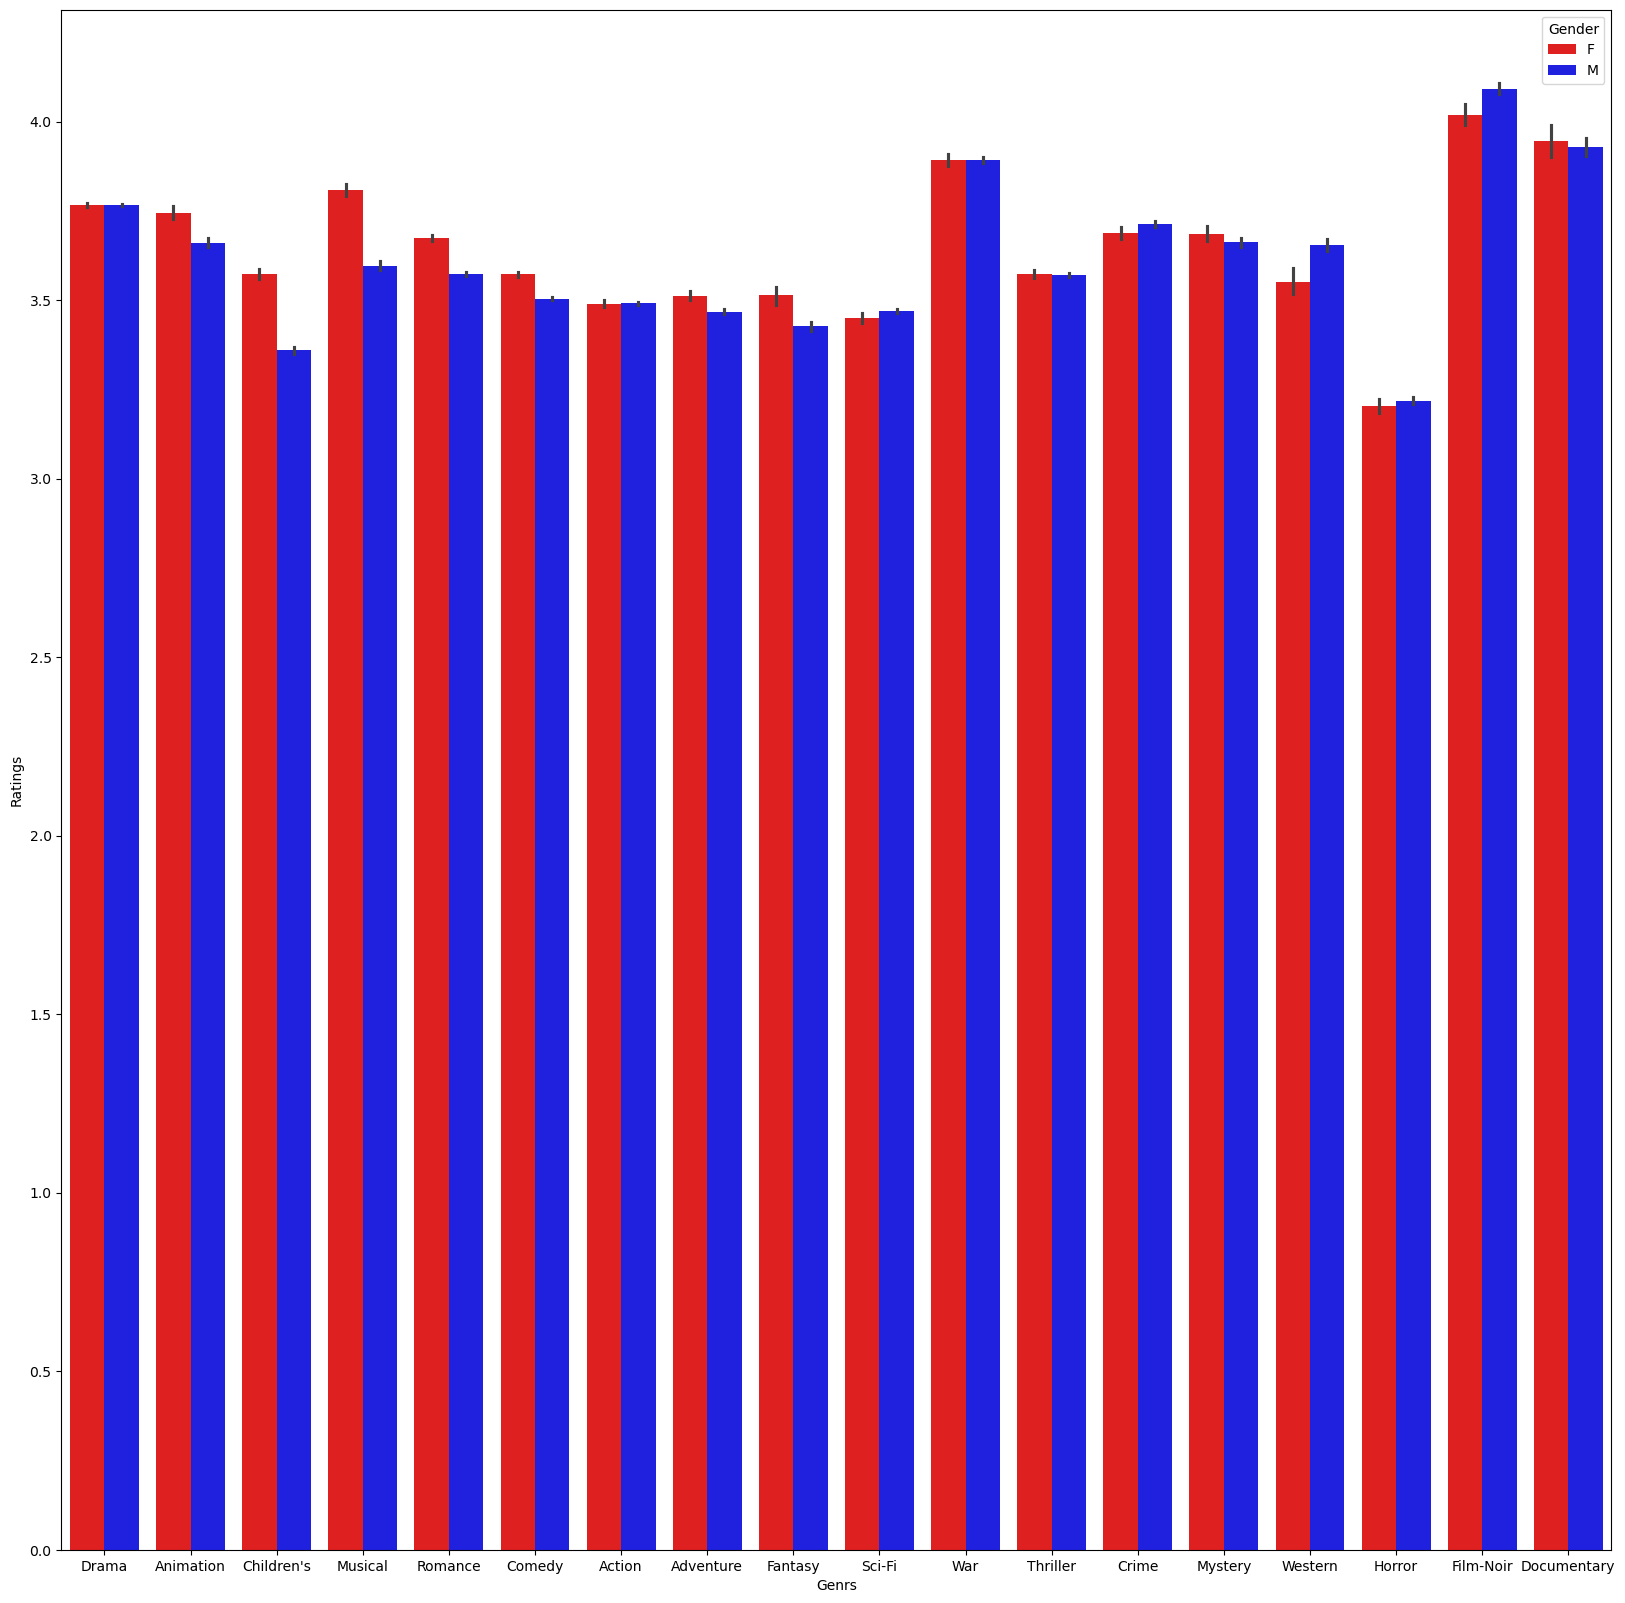

In [27]:
plt.figure(figsize=(20, 20))
sns.barplot(
    y='Ratings',
    x='Genrs',
    hue='Gender',
    data=favorite_table_exploded,
    palette=palette
    )

**Insights**:
   
- Females generally give higher average ratings than males.

- Men tend to rate film noir, documentary, and war films more highly, indicating a preference for these genres.

- Women prefer documentary, musical, romance, and children's movies more than men.

- The war and action genres have similar average ratings for both men and women.

- Horror movies receive lower ratings from both genders.

### Age distribution for each category

<Axes: xlabel='Age', ylabel='Ratings'>

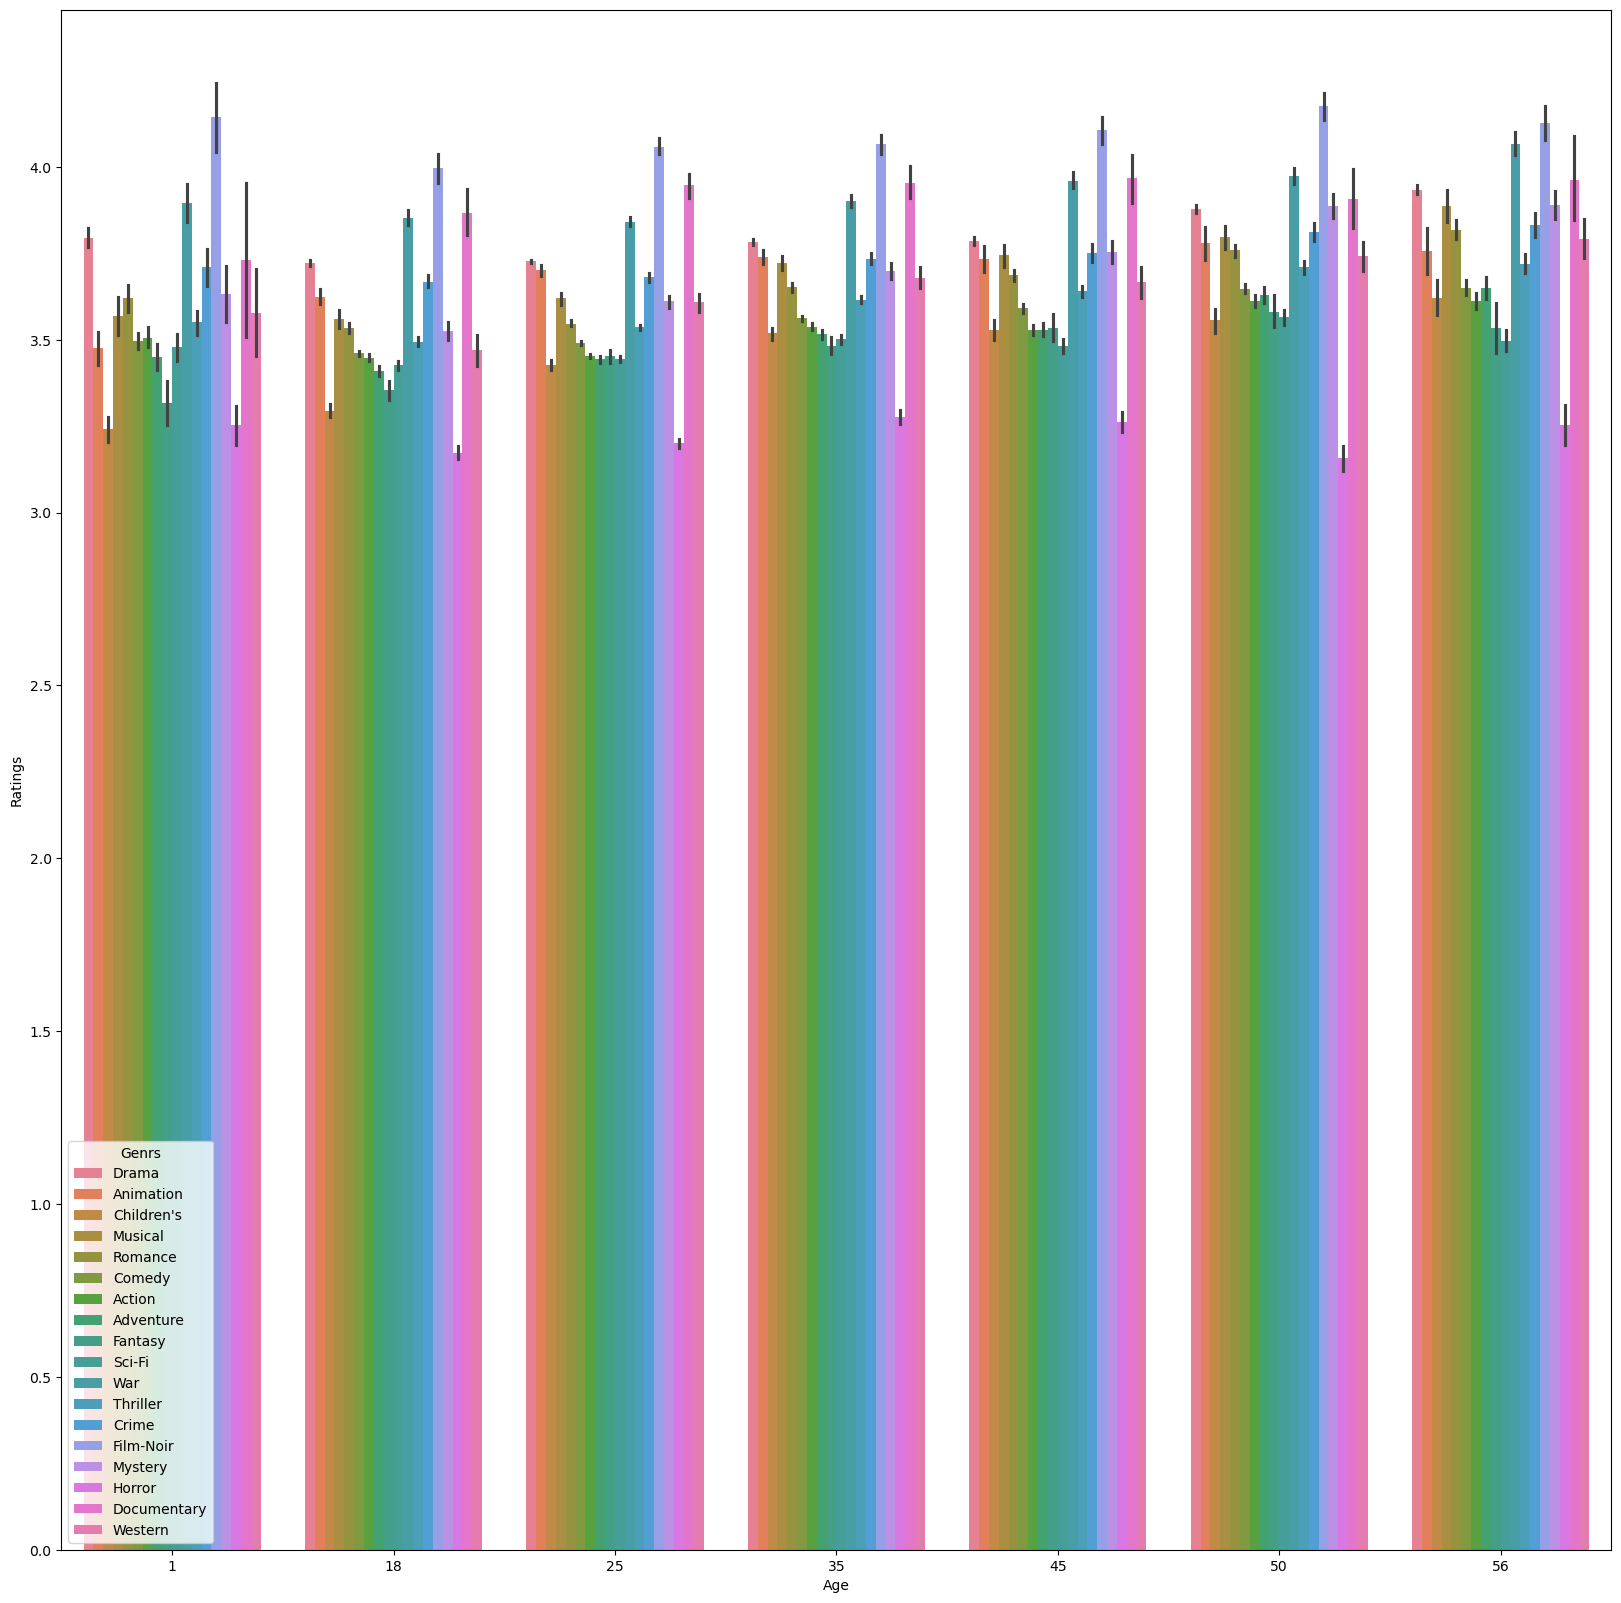

In [28]:
plt.figure(figsize=(20, 20))
sns.barplot(
    y='Ratings',
    hue='Genrs',
    x='Age',
    data=favorite_table_exploded,)

C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_25444\3756006164.py:18: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(


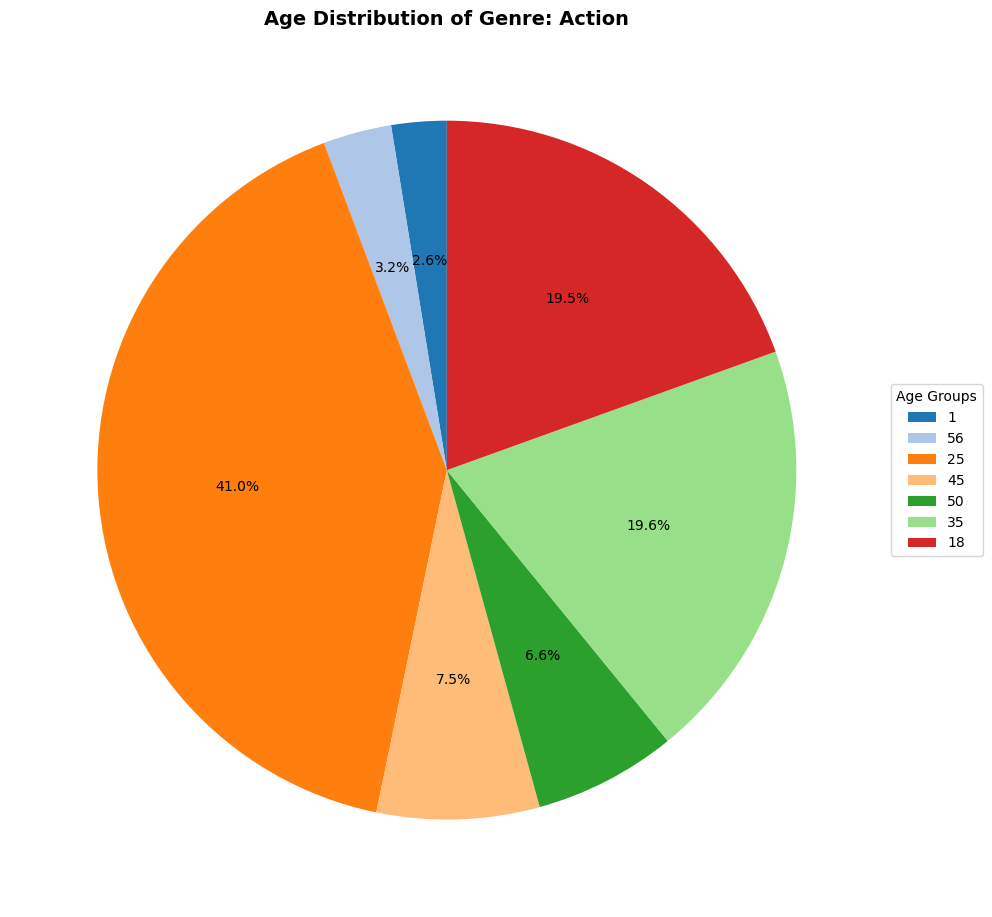

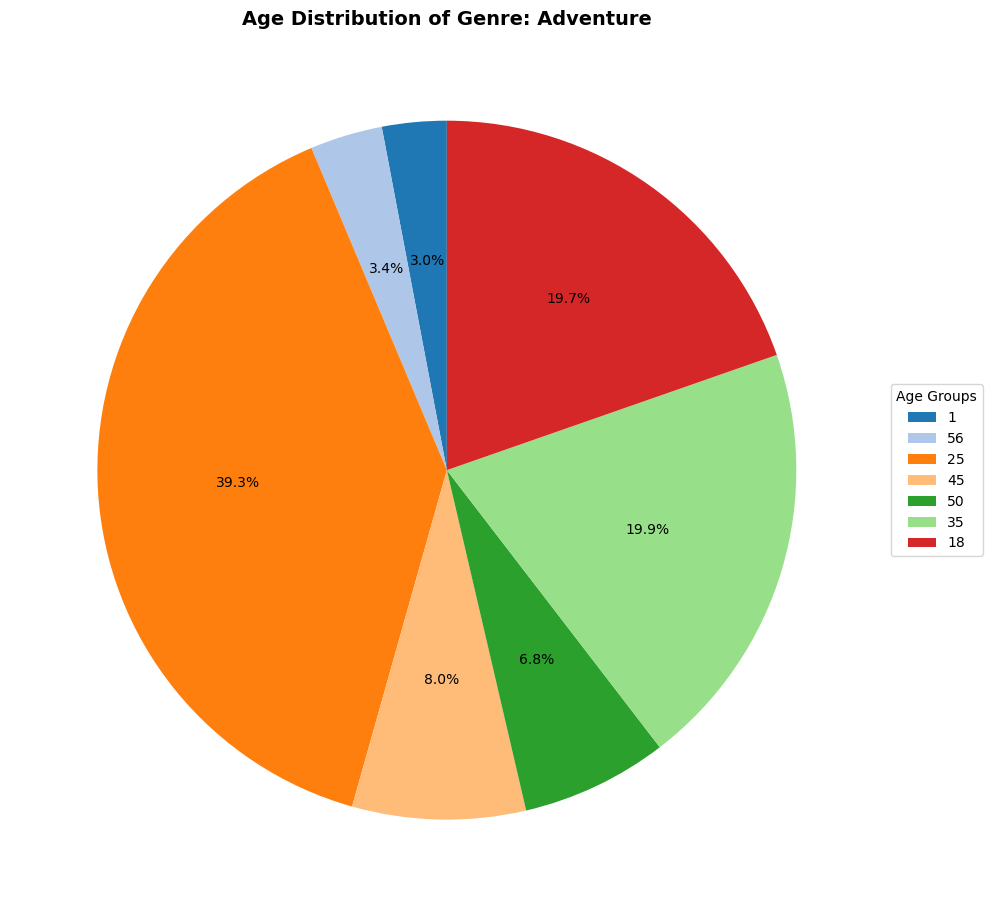

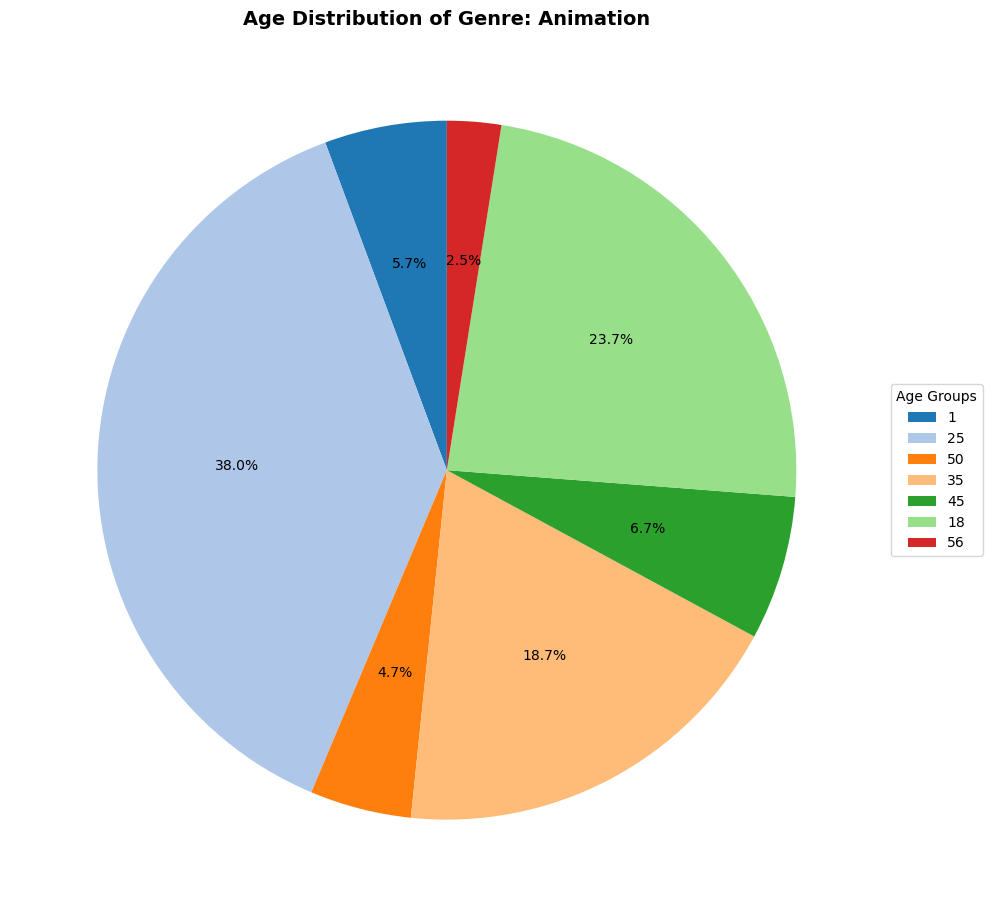

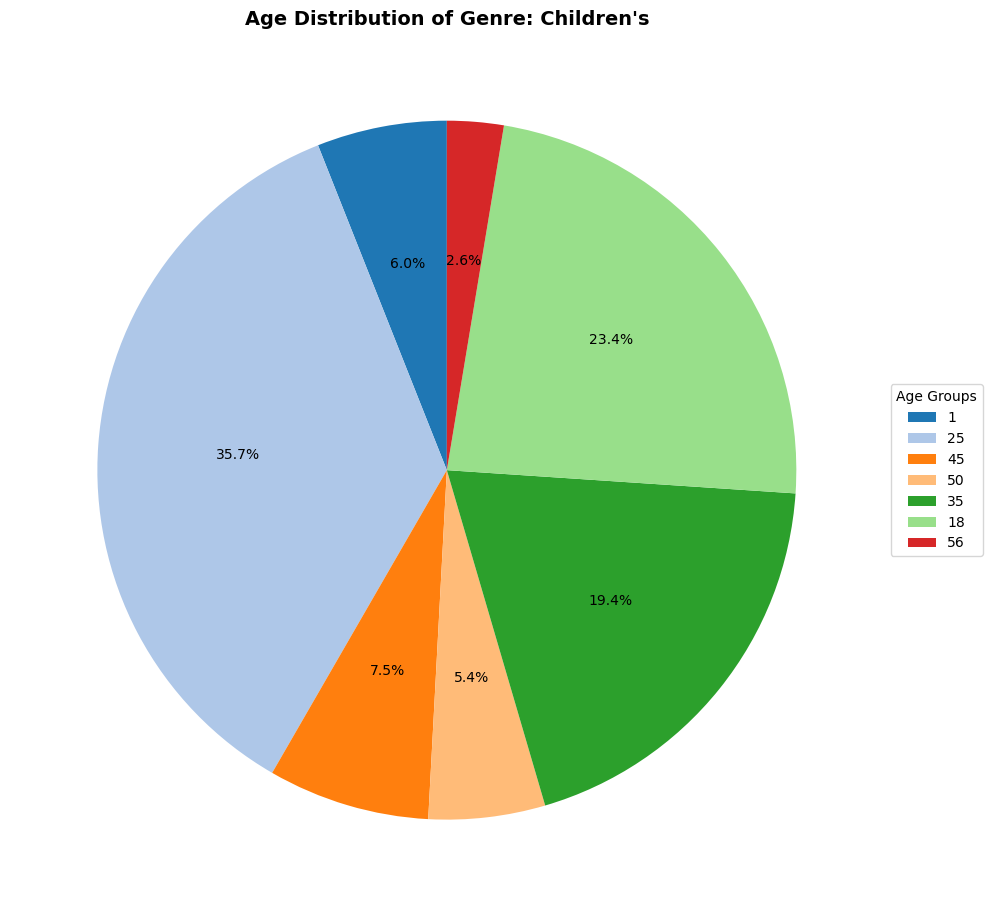

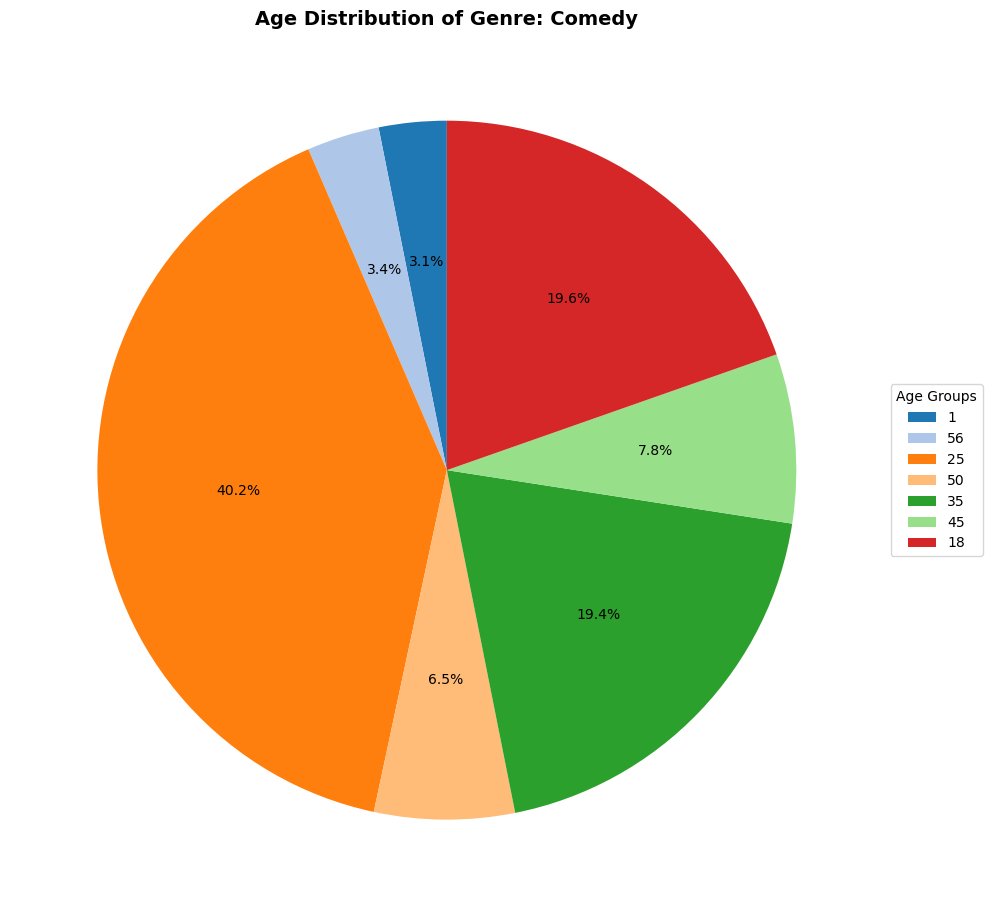

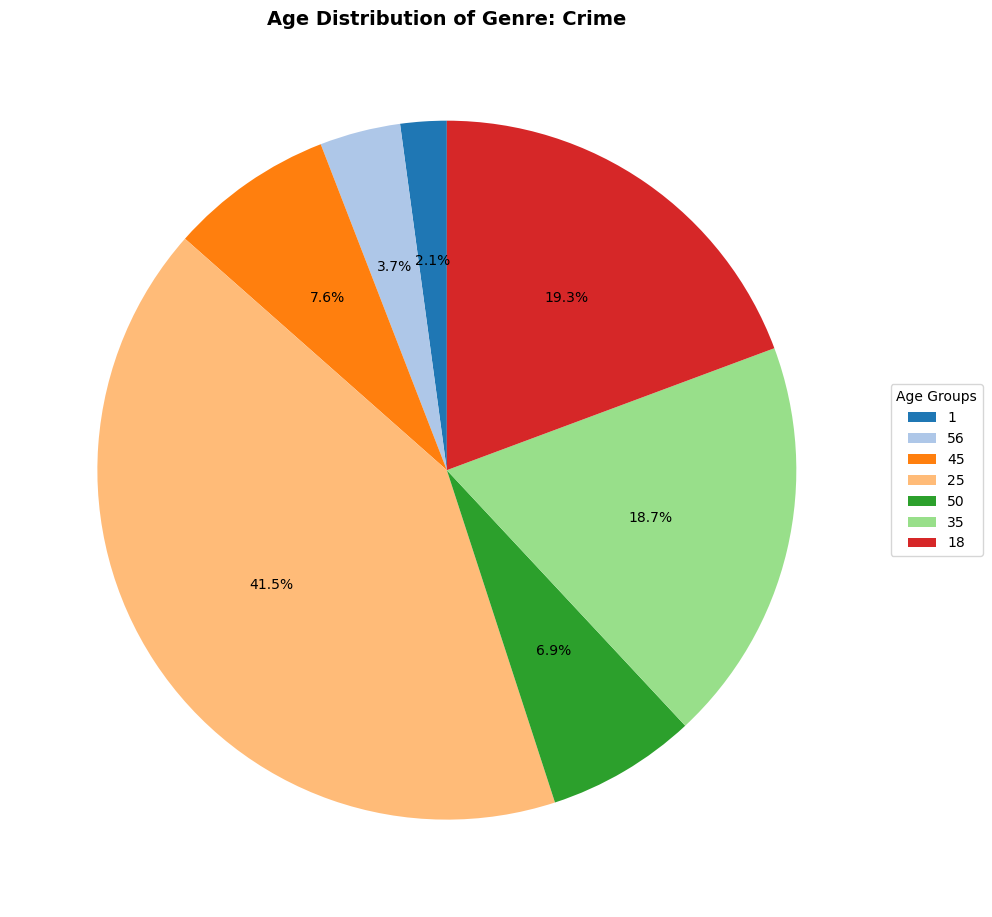

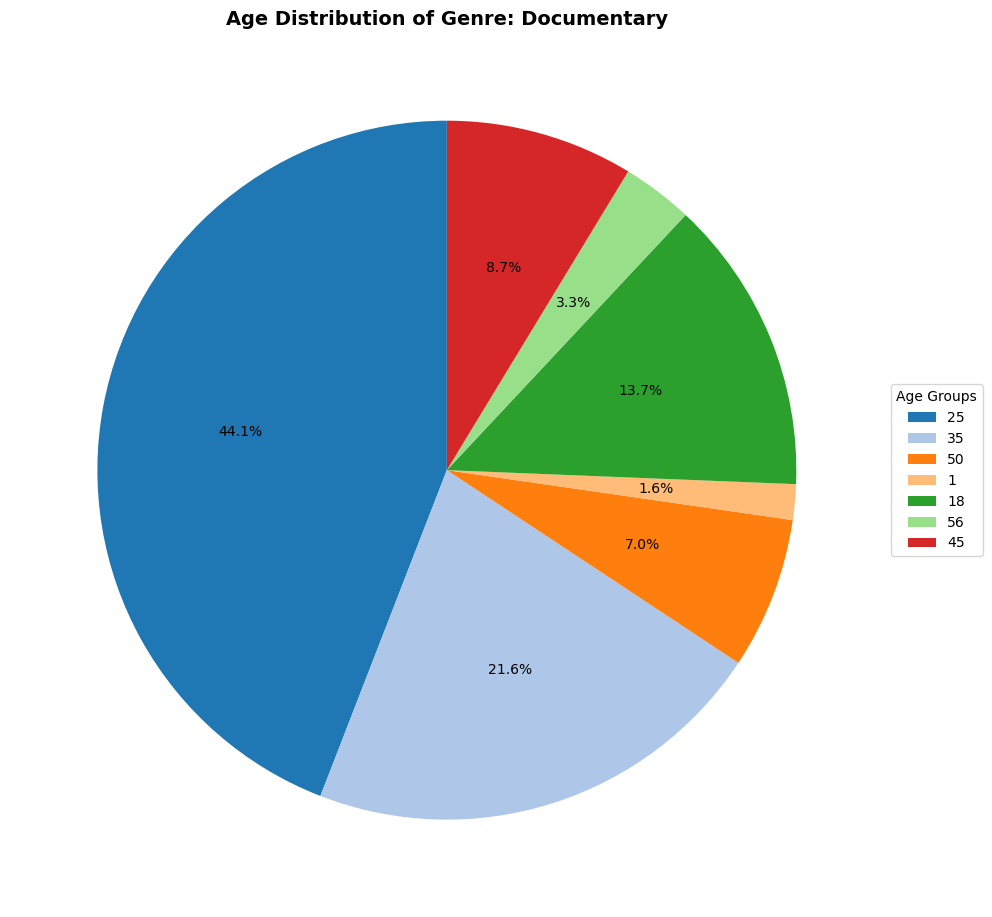

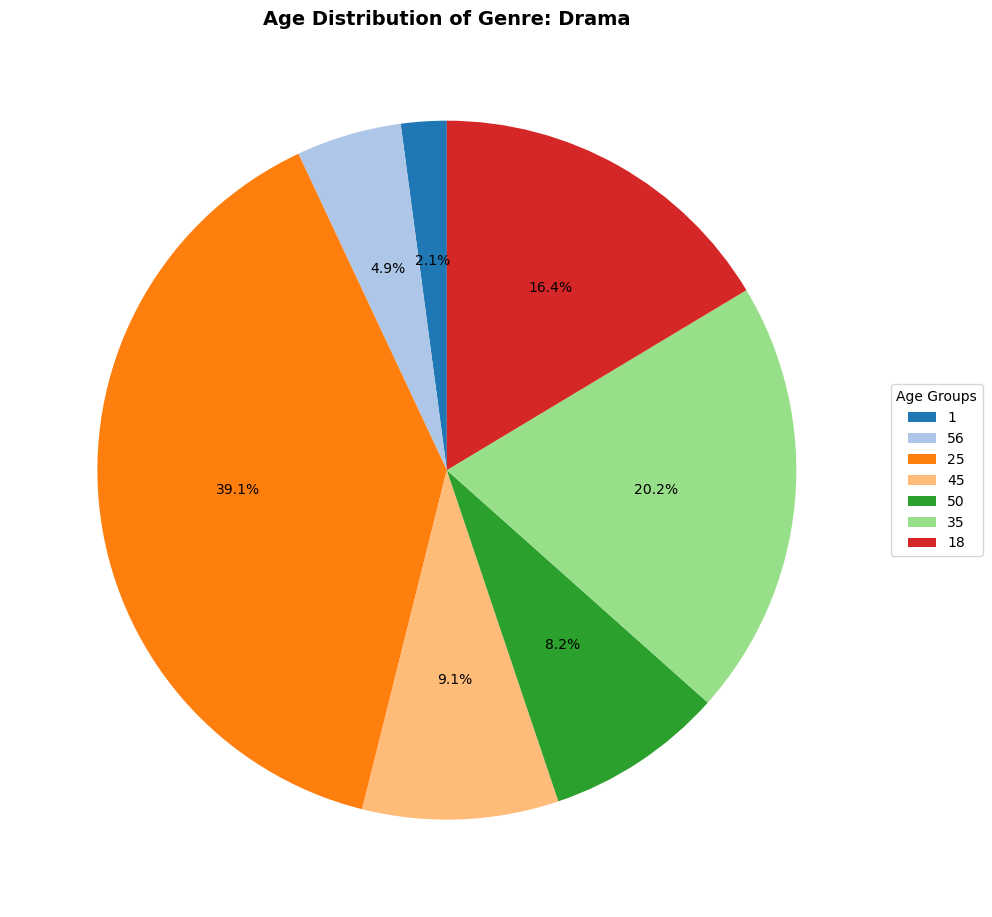

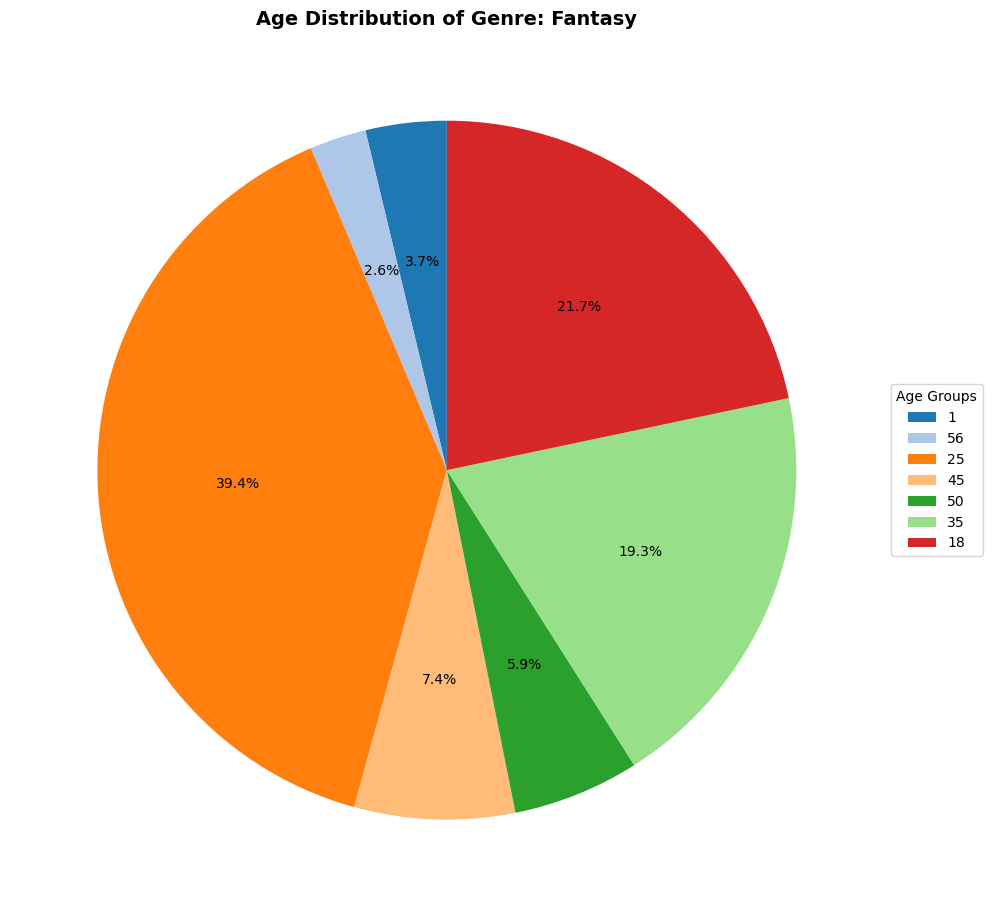

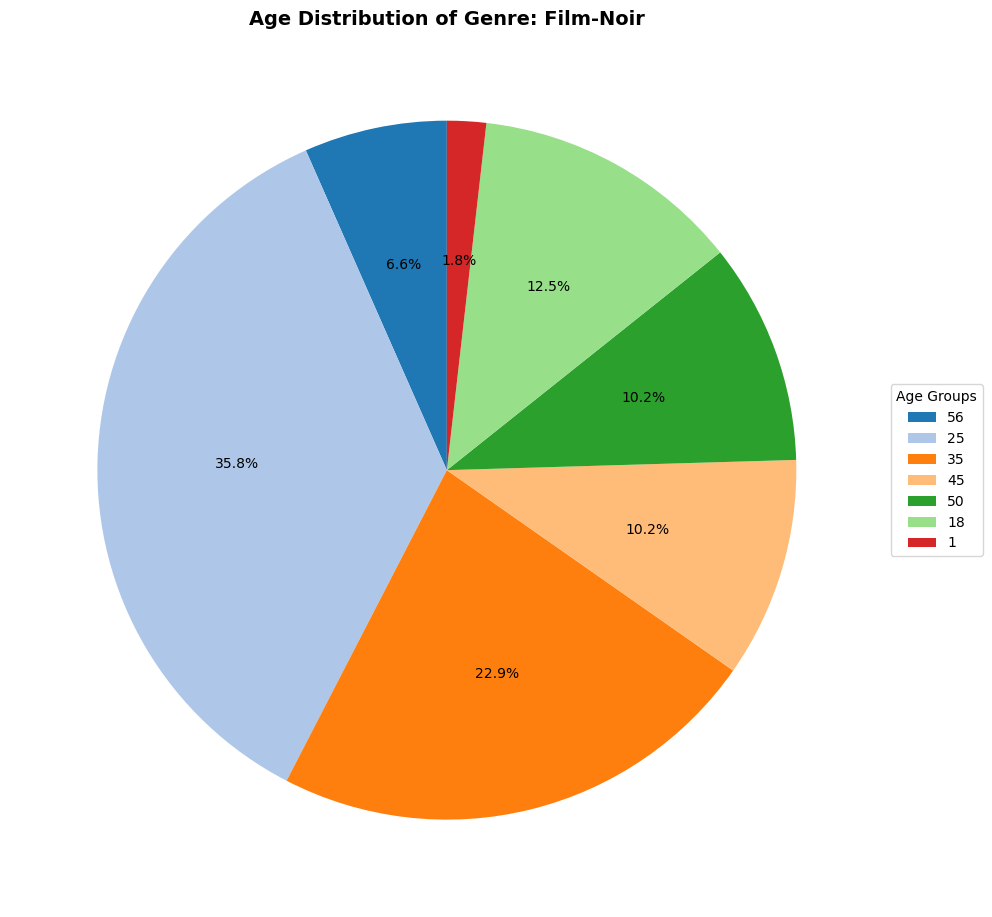

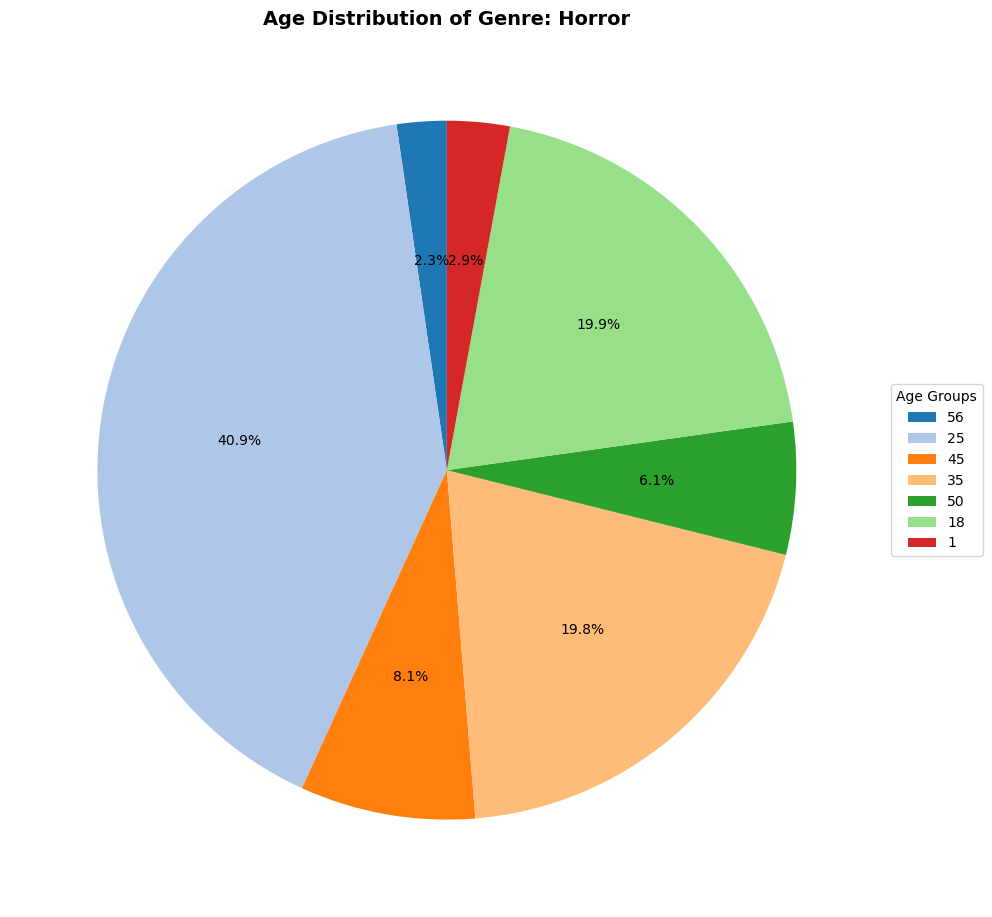

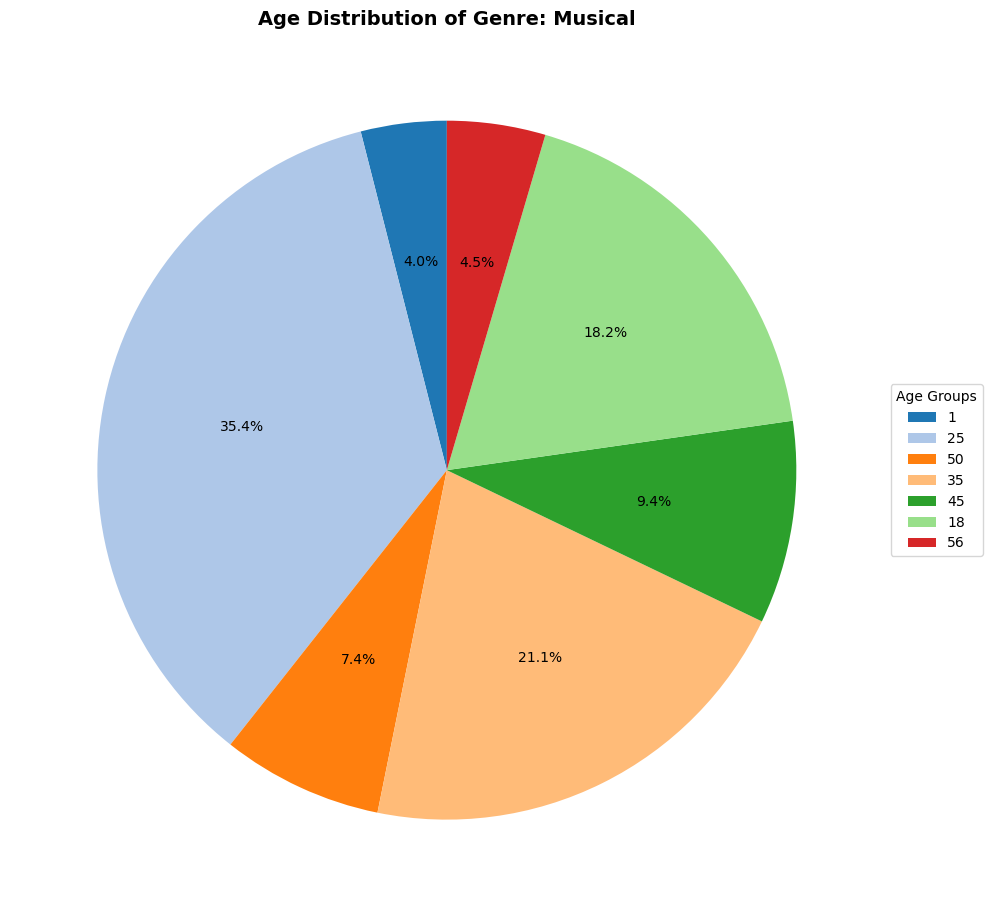

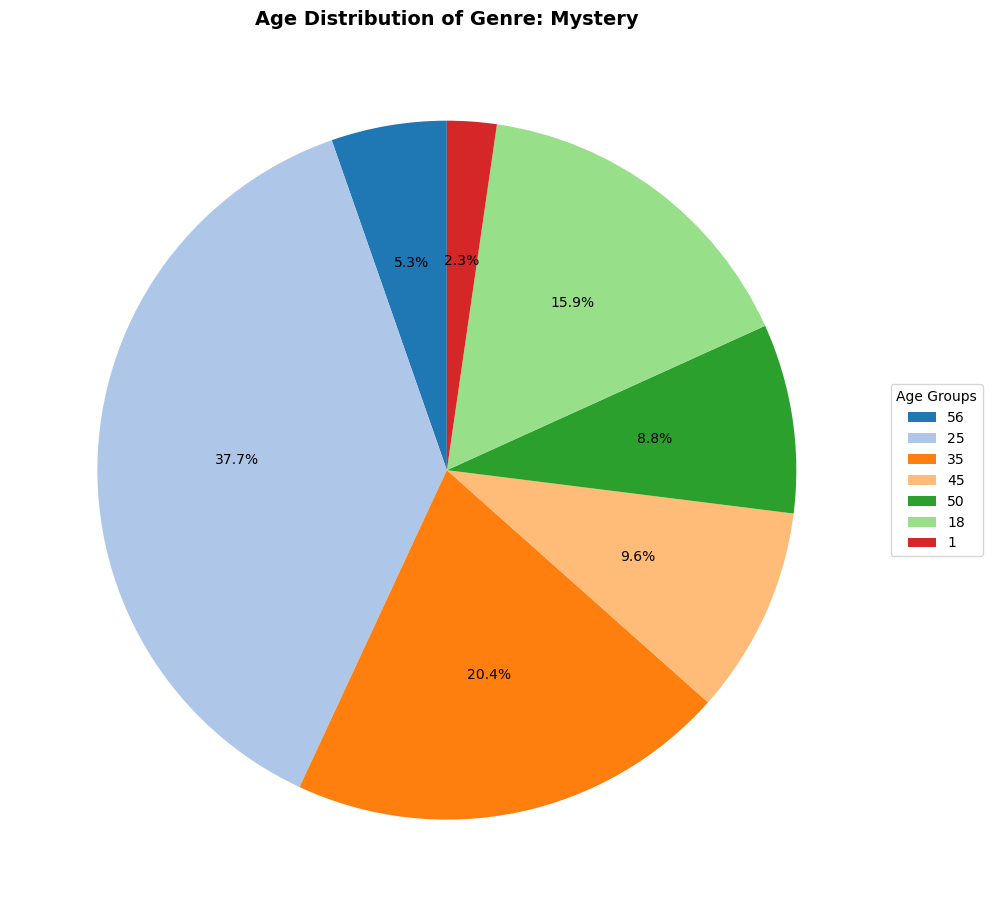

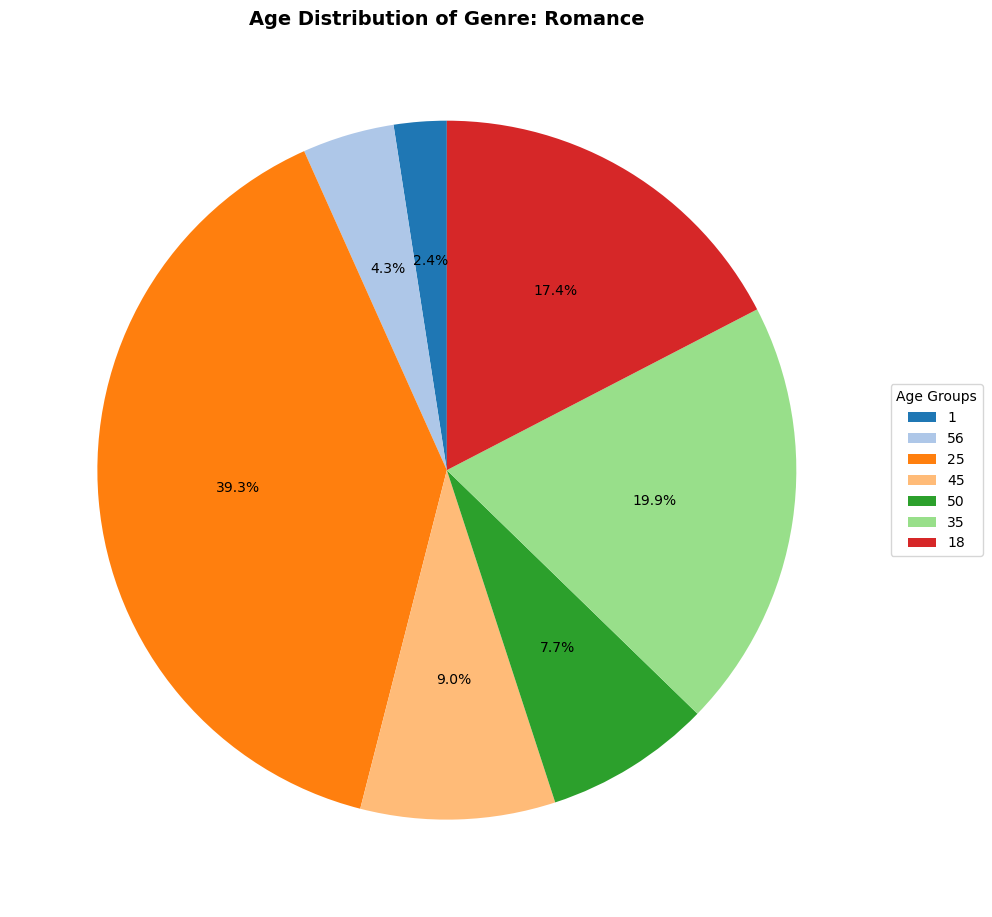

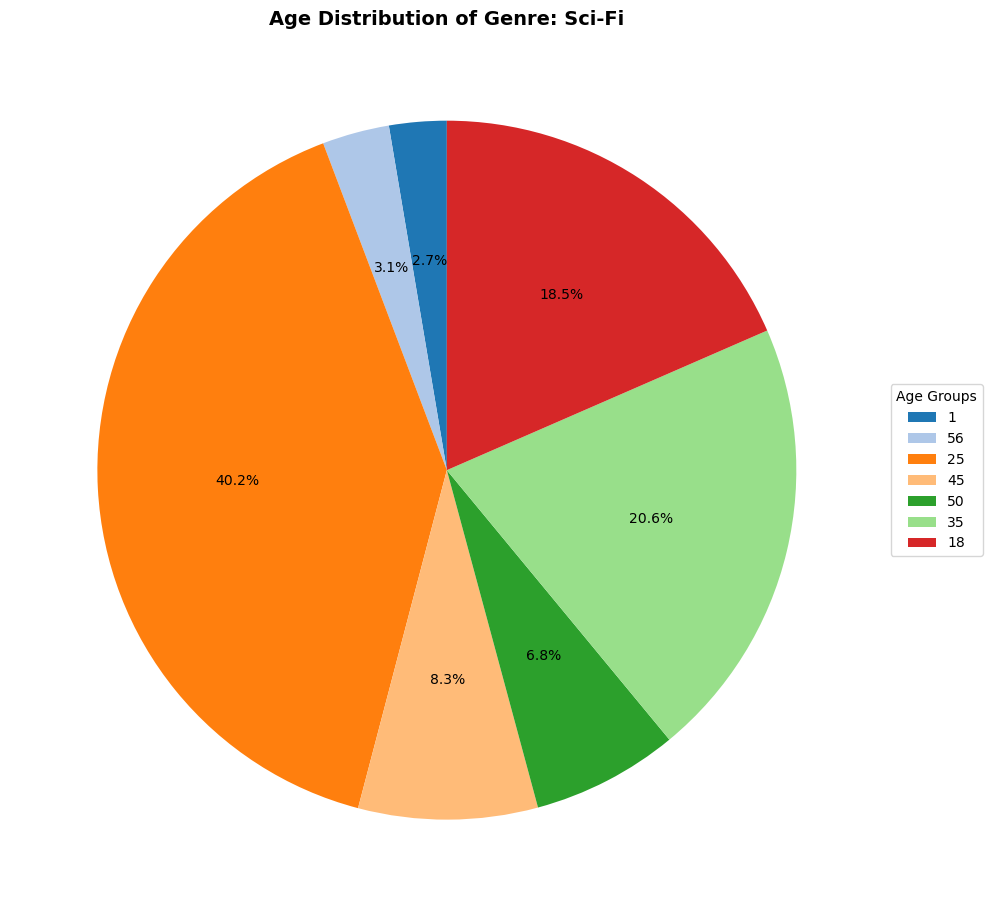

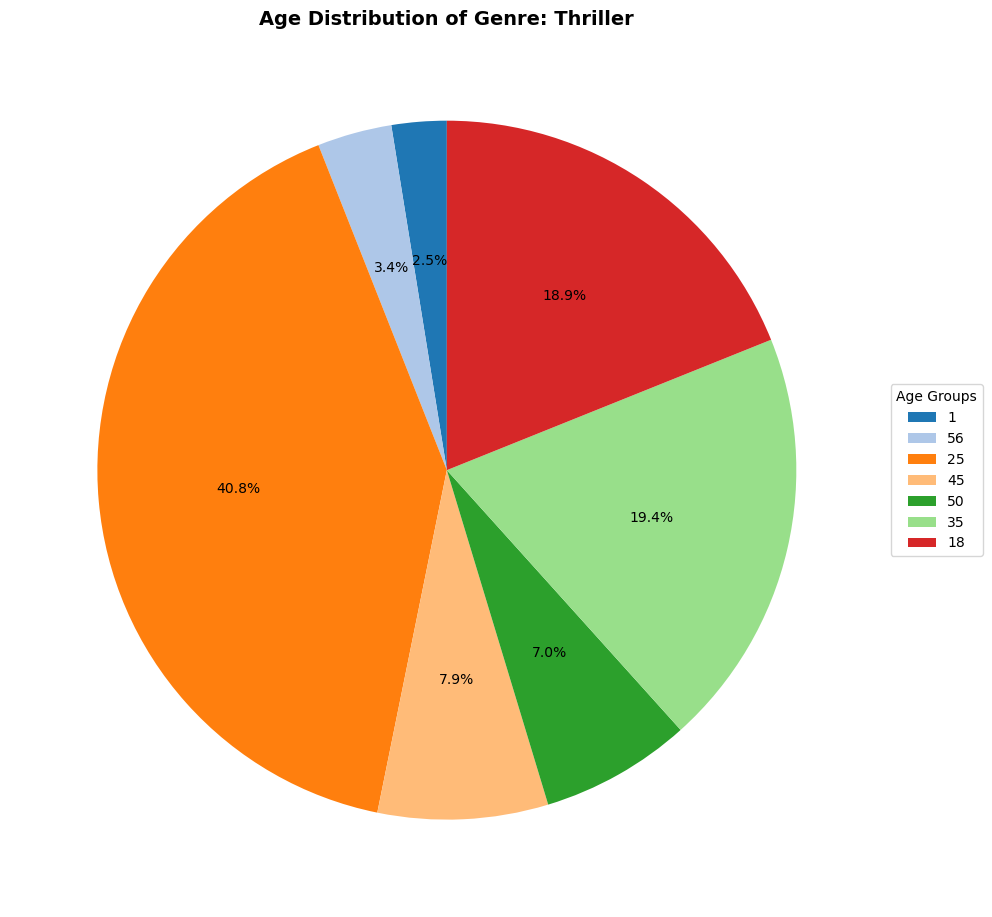

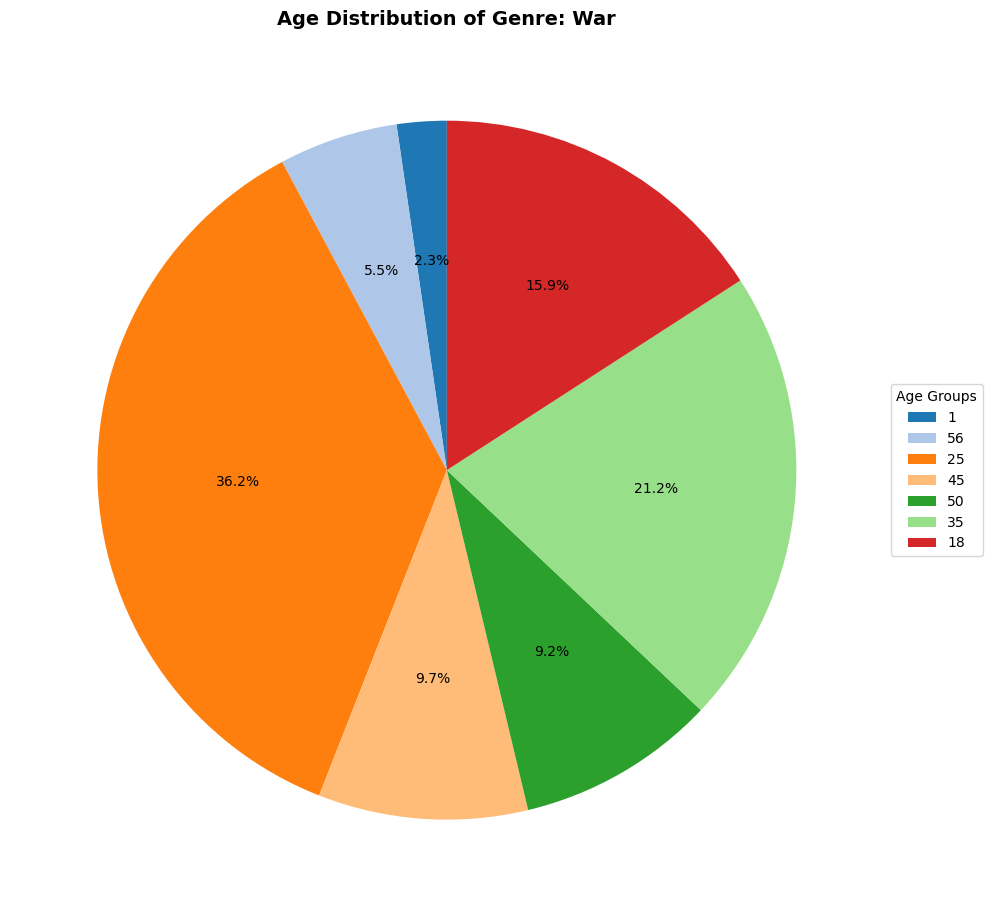

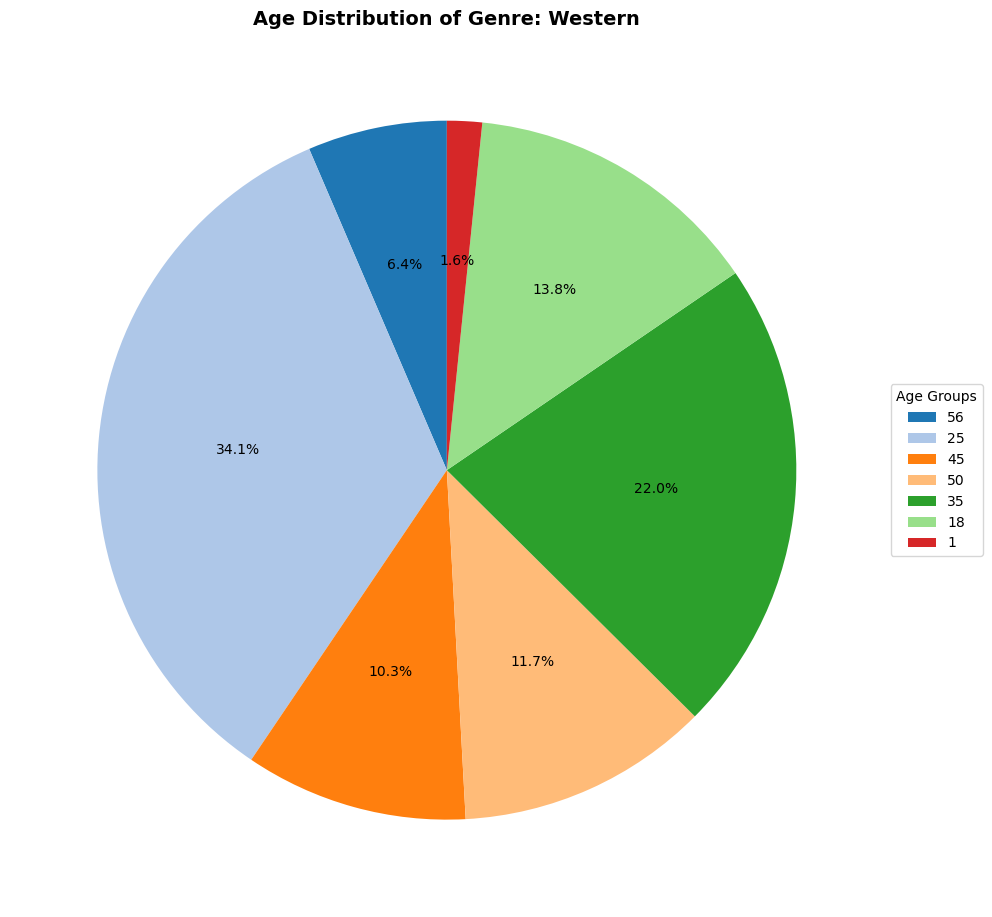

In [29]:

grouped_data = favorite_table_exploded.groupby('Genrs')


for genre, group in grouped_data:

    age_counts = group['Age'].value_counts(sort=False)
    age_counts = age_counts[age_counts > 0]

    
    plt.figure(figsize=(10, 10))
    wedges, texts, autotexts = plt.pie(
        age_counts,
        labels=None,  
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.tab20.colors[:len(age_counts)]
    )
    plt.legend(
        wedges,  
        labels=age_counts.index,
        title="Age Groups",
        loc="center left",
        bbox_to_anchor=(1, 0.5)  
    )
    plt.title(f"Age Distribution of Genre: {genre}", fontsize=14, fontweight='bold')
    plt.tight_layout()  
    plt.show()

**Insights**:

- Individuals aged 25-34 tend to rate more movies compared to other age groups.

- Action movies are particularly favored by people aged 18-45.

- Animation movies are most popular among individuals aged 18-25.

- Documentary movies are preferred by people in the age range of 25-35.

### Favorite category in each region

<Axes: xlabel='zone', ylabel='Ratings'>

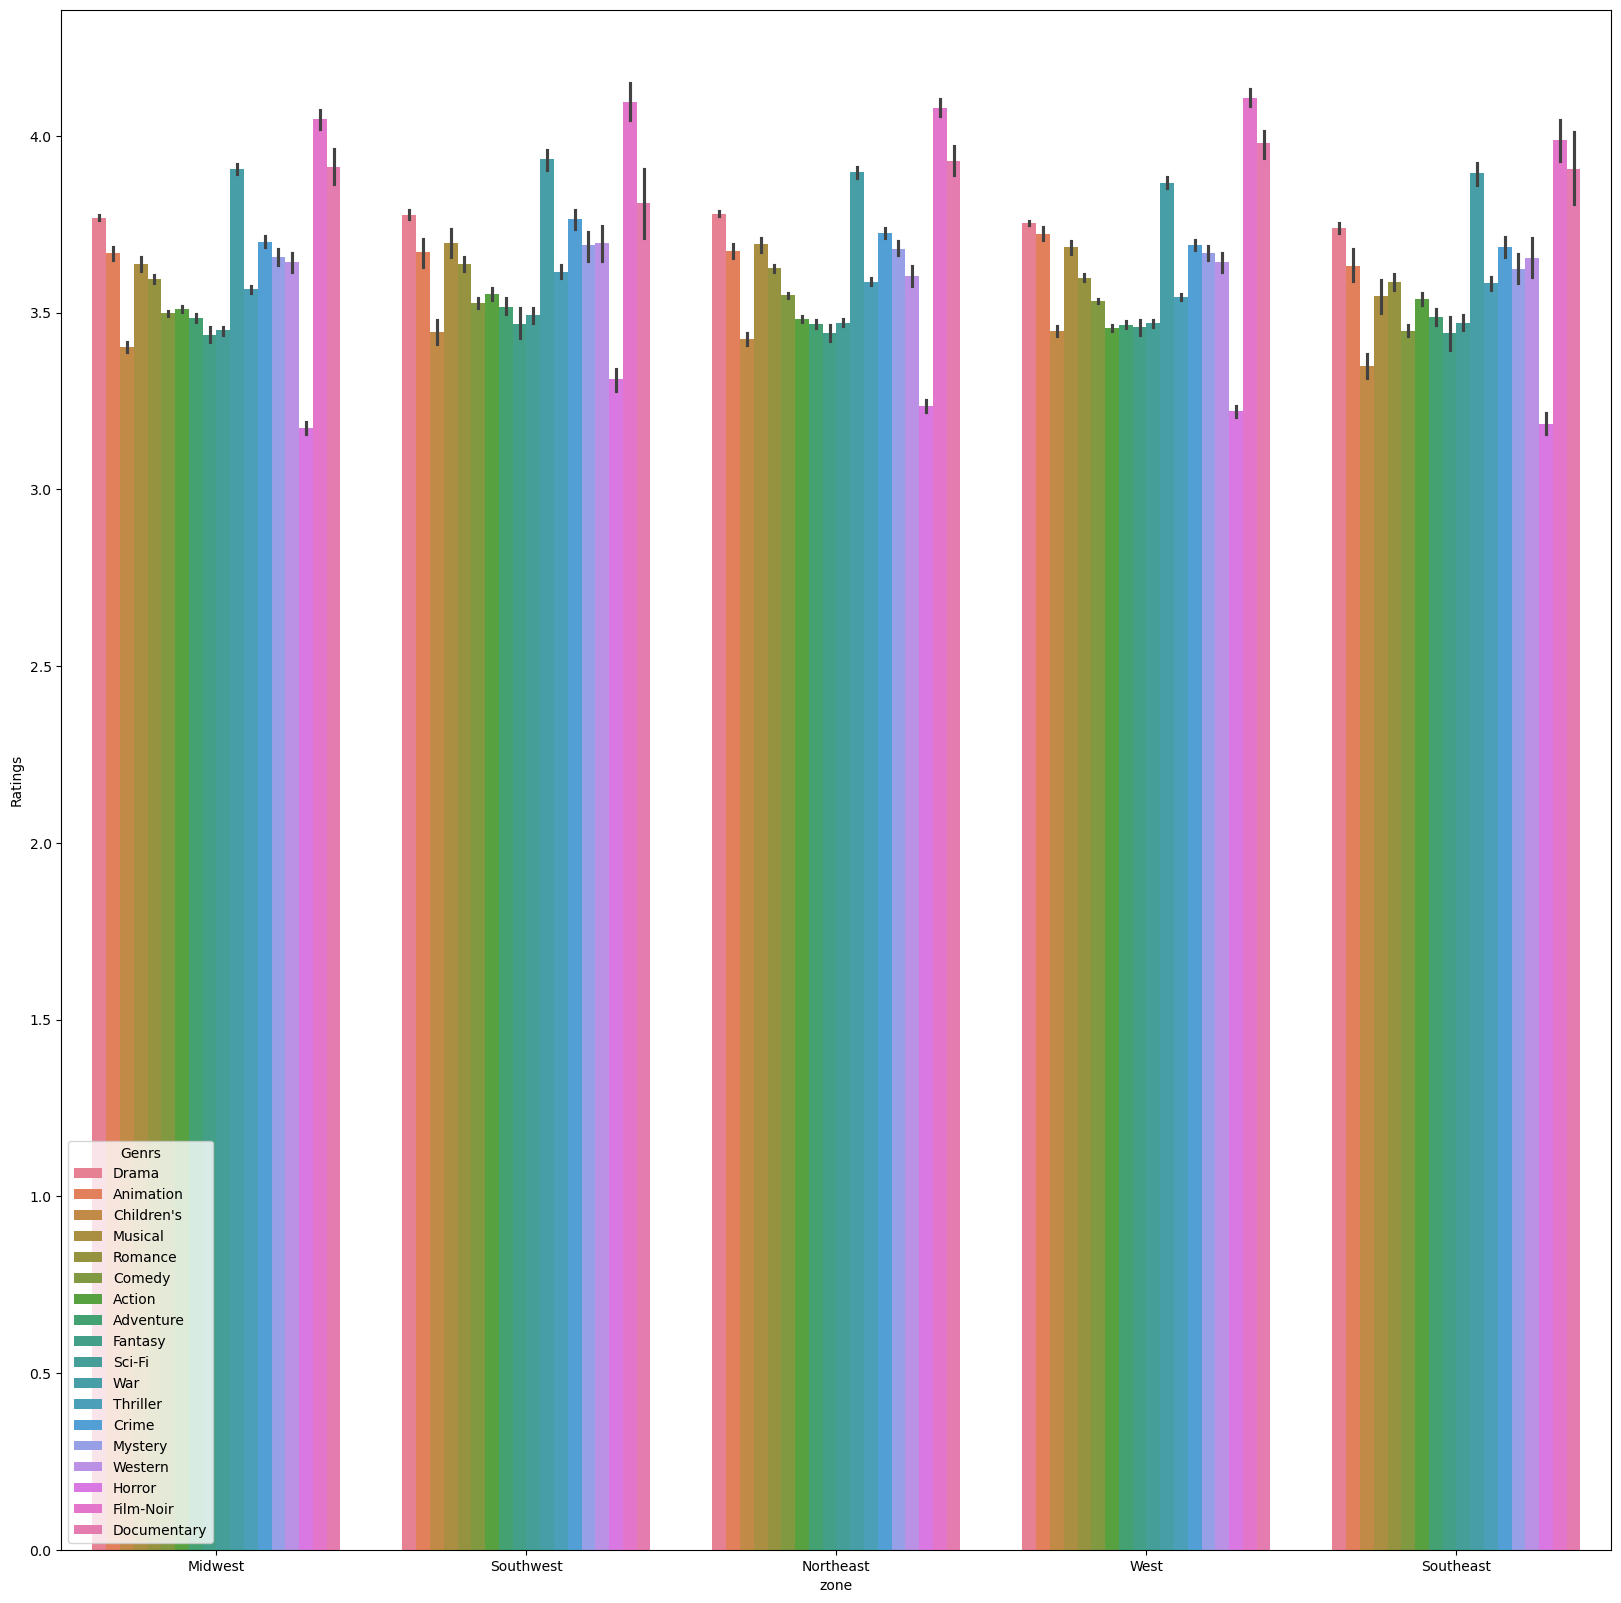

In [30]:
plt.figure(figsize=(20,20))
sns.barplot(
    y='Ratings',
    x='zone',
    hue='Genrs',
    data=favorite_table_exploded,)



<Axes: xlabel='Occupation', ylabel='Ratings'>

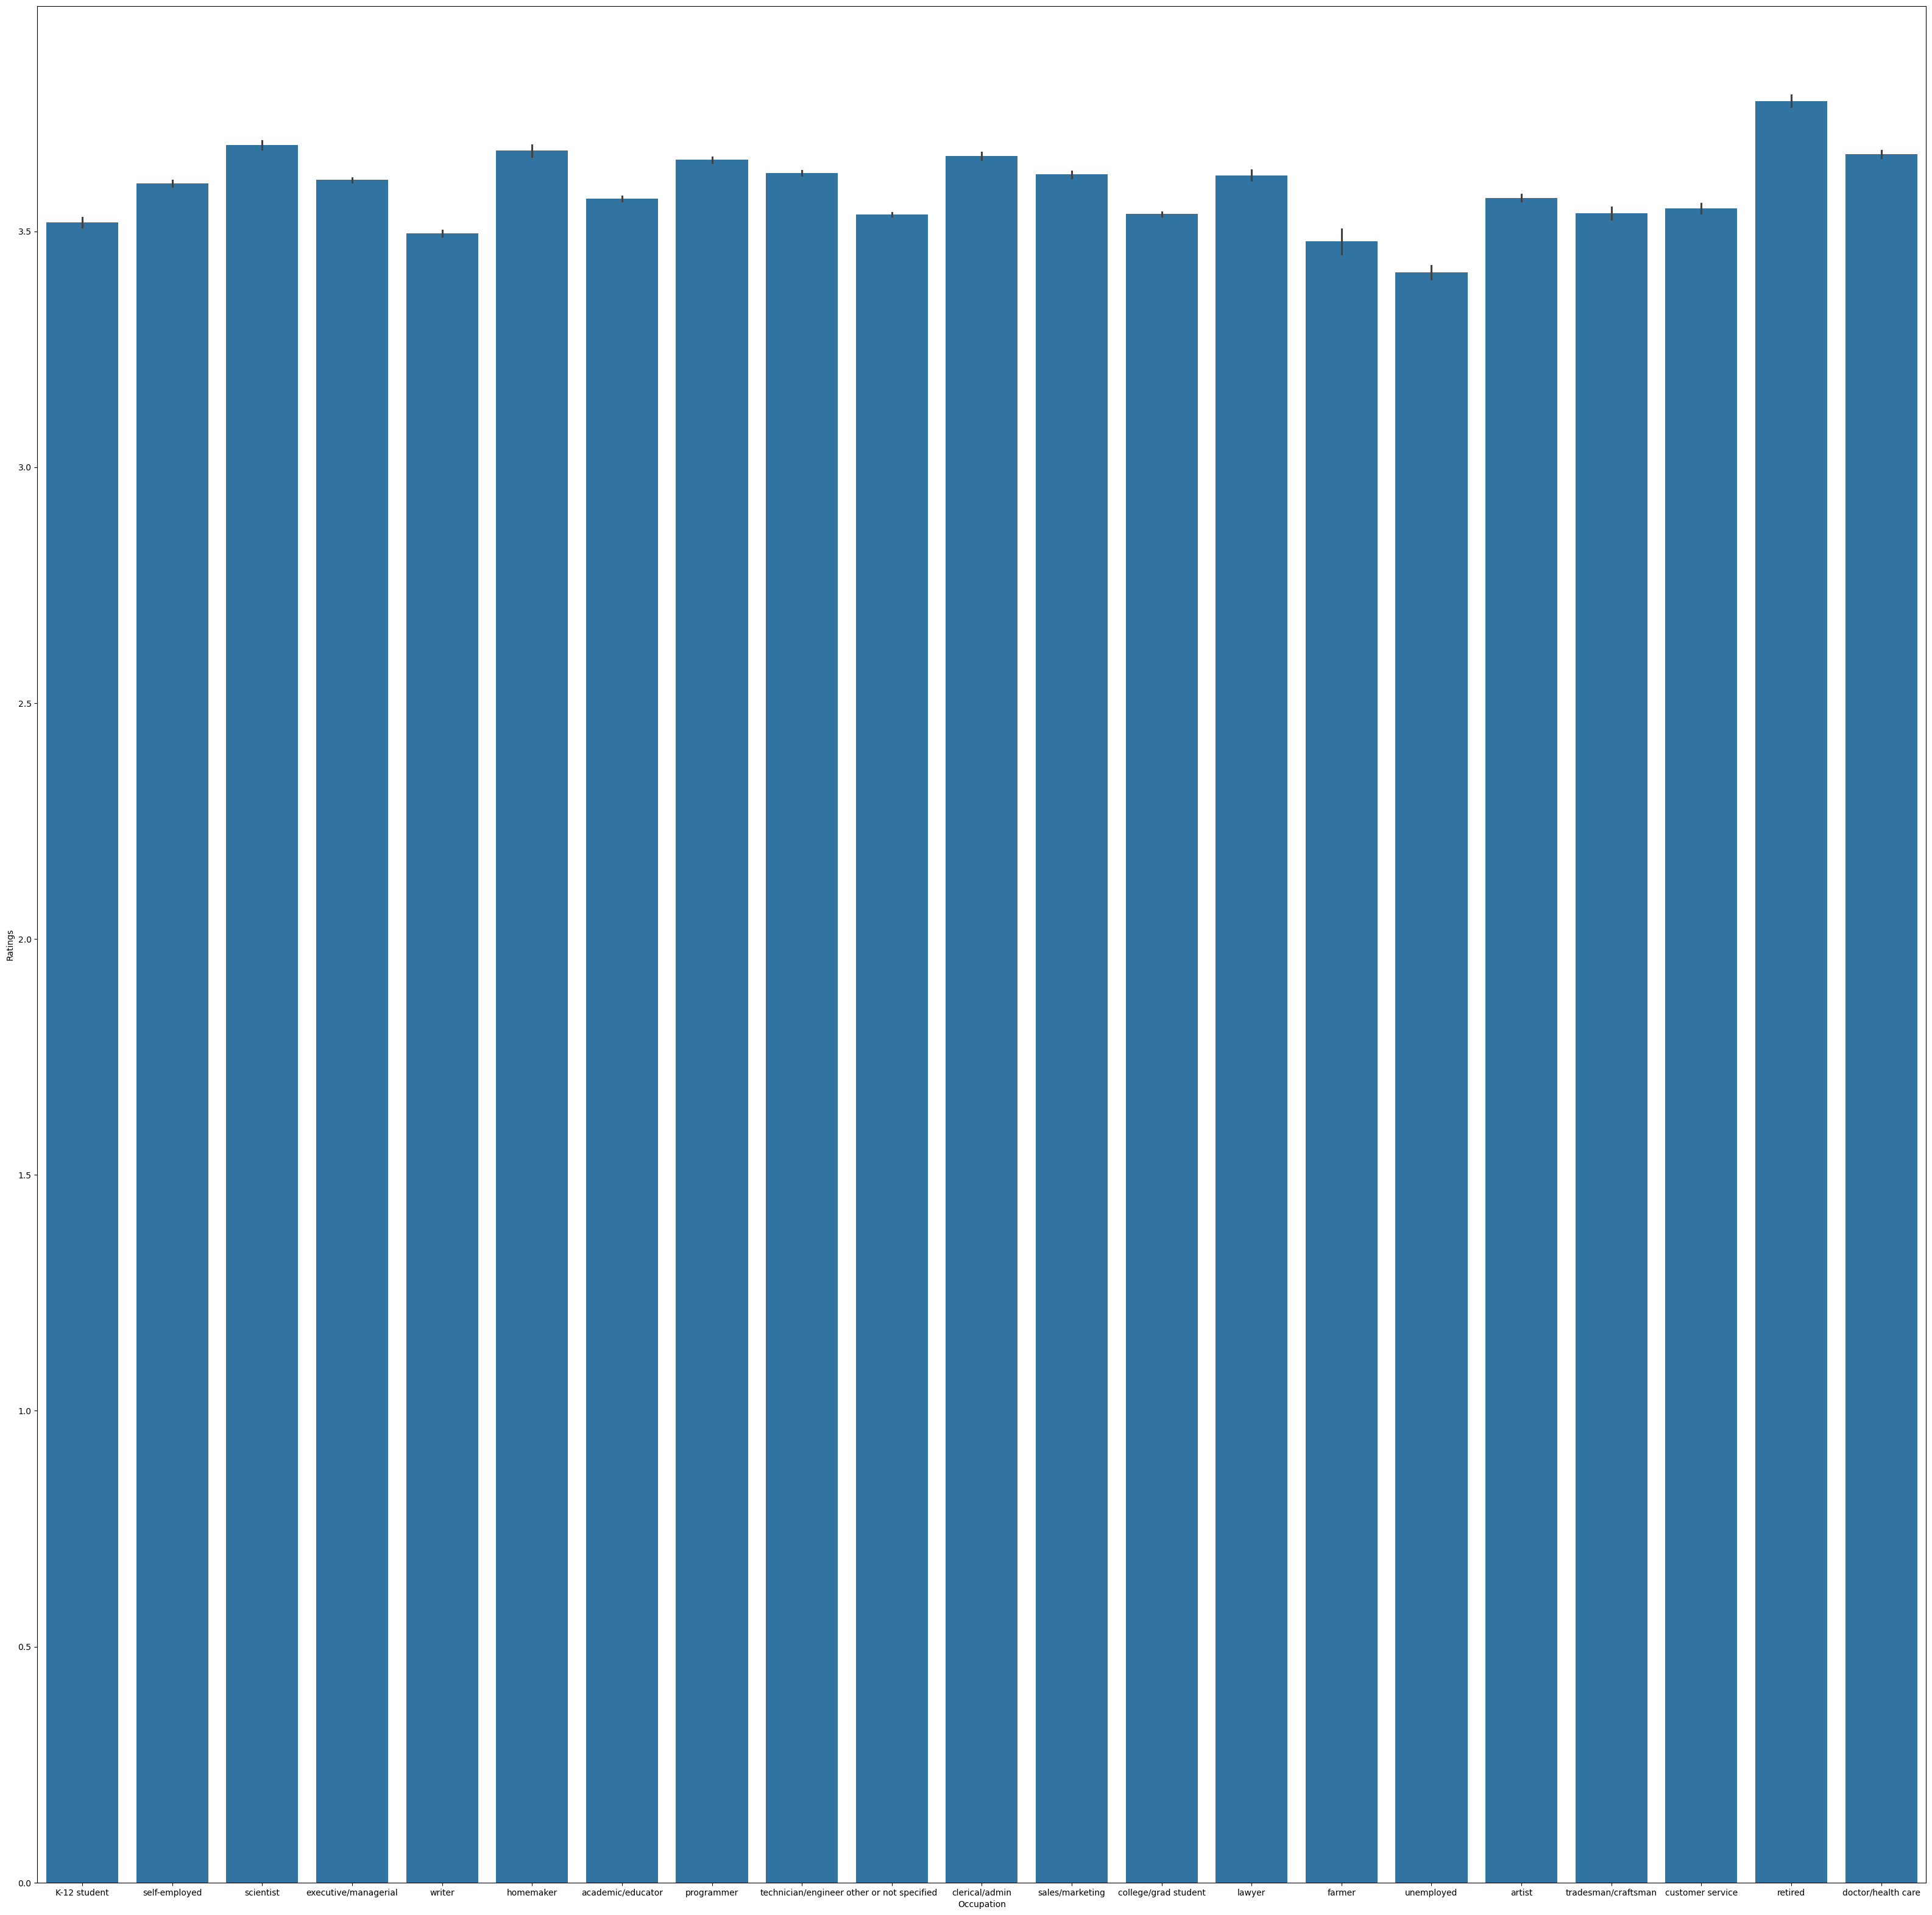

In [31]:
plt.figure(figsize=(40,40))
sns.barplot(
    x='Occupation',
    y='Ratings',
    data=favorite_table_exploded)


### Movies year of reales mean in each category

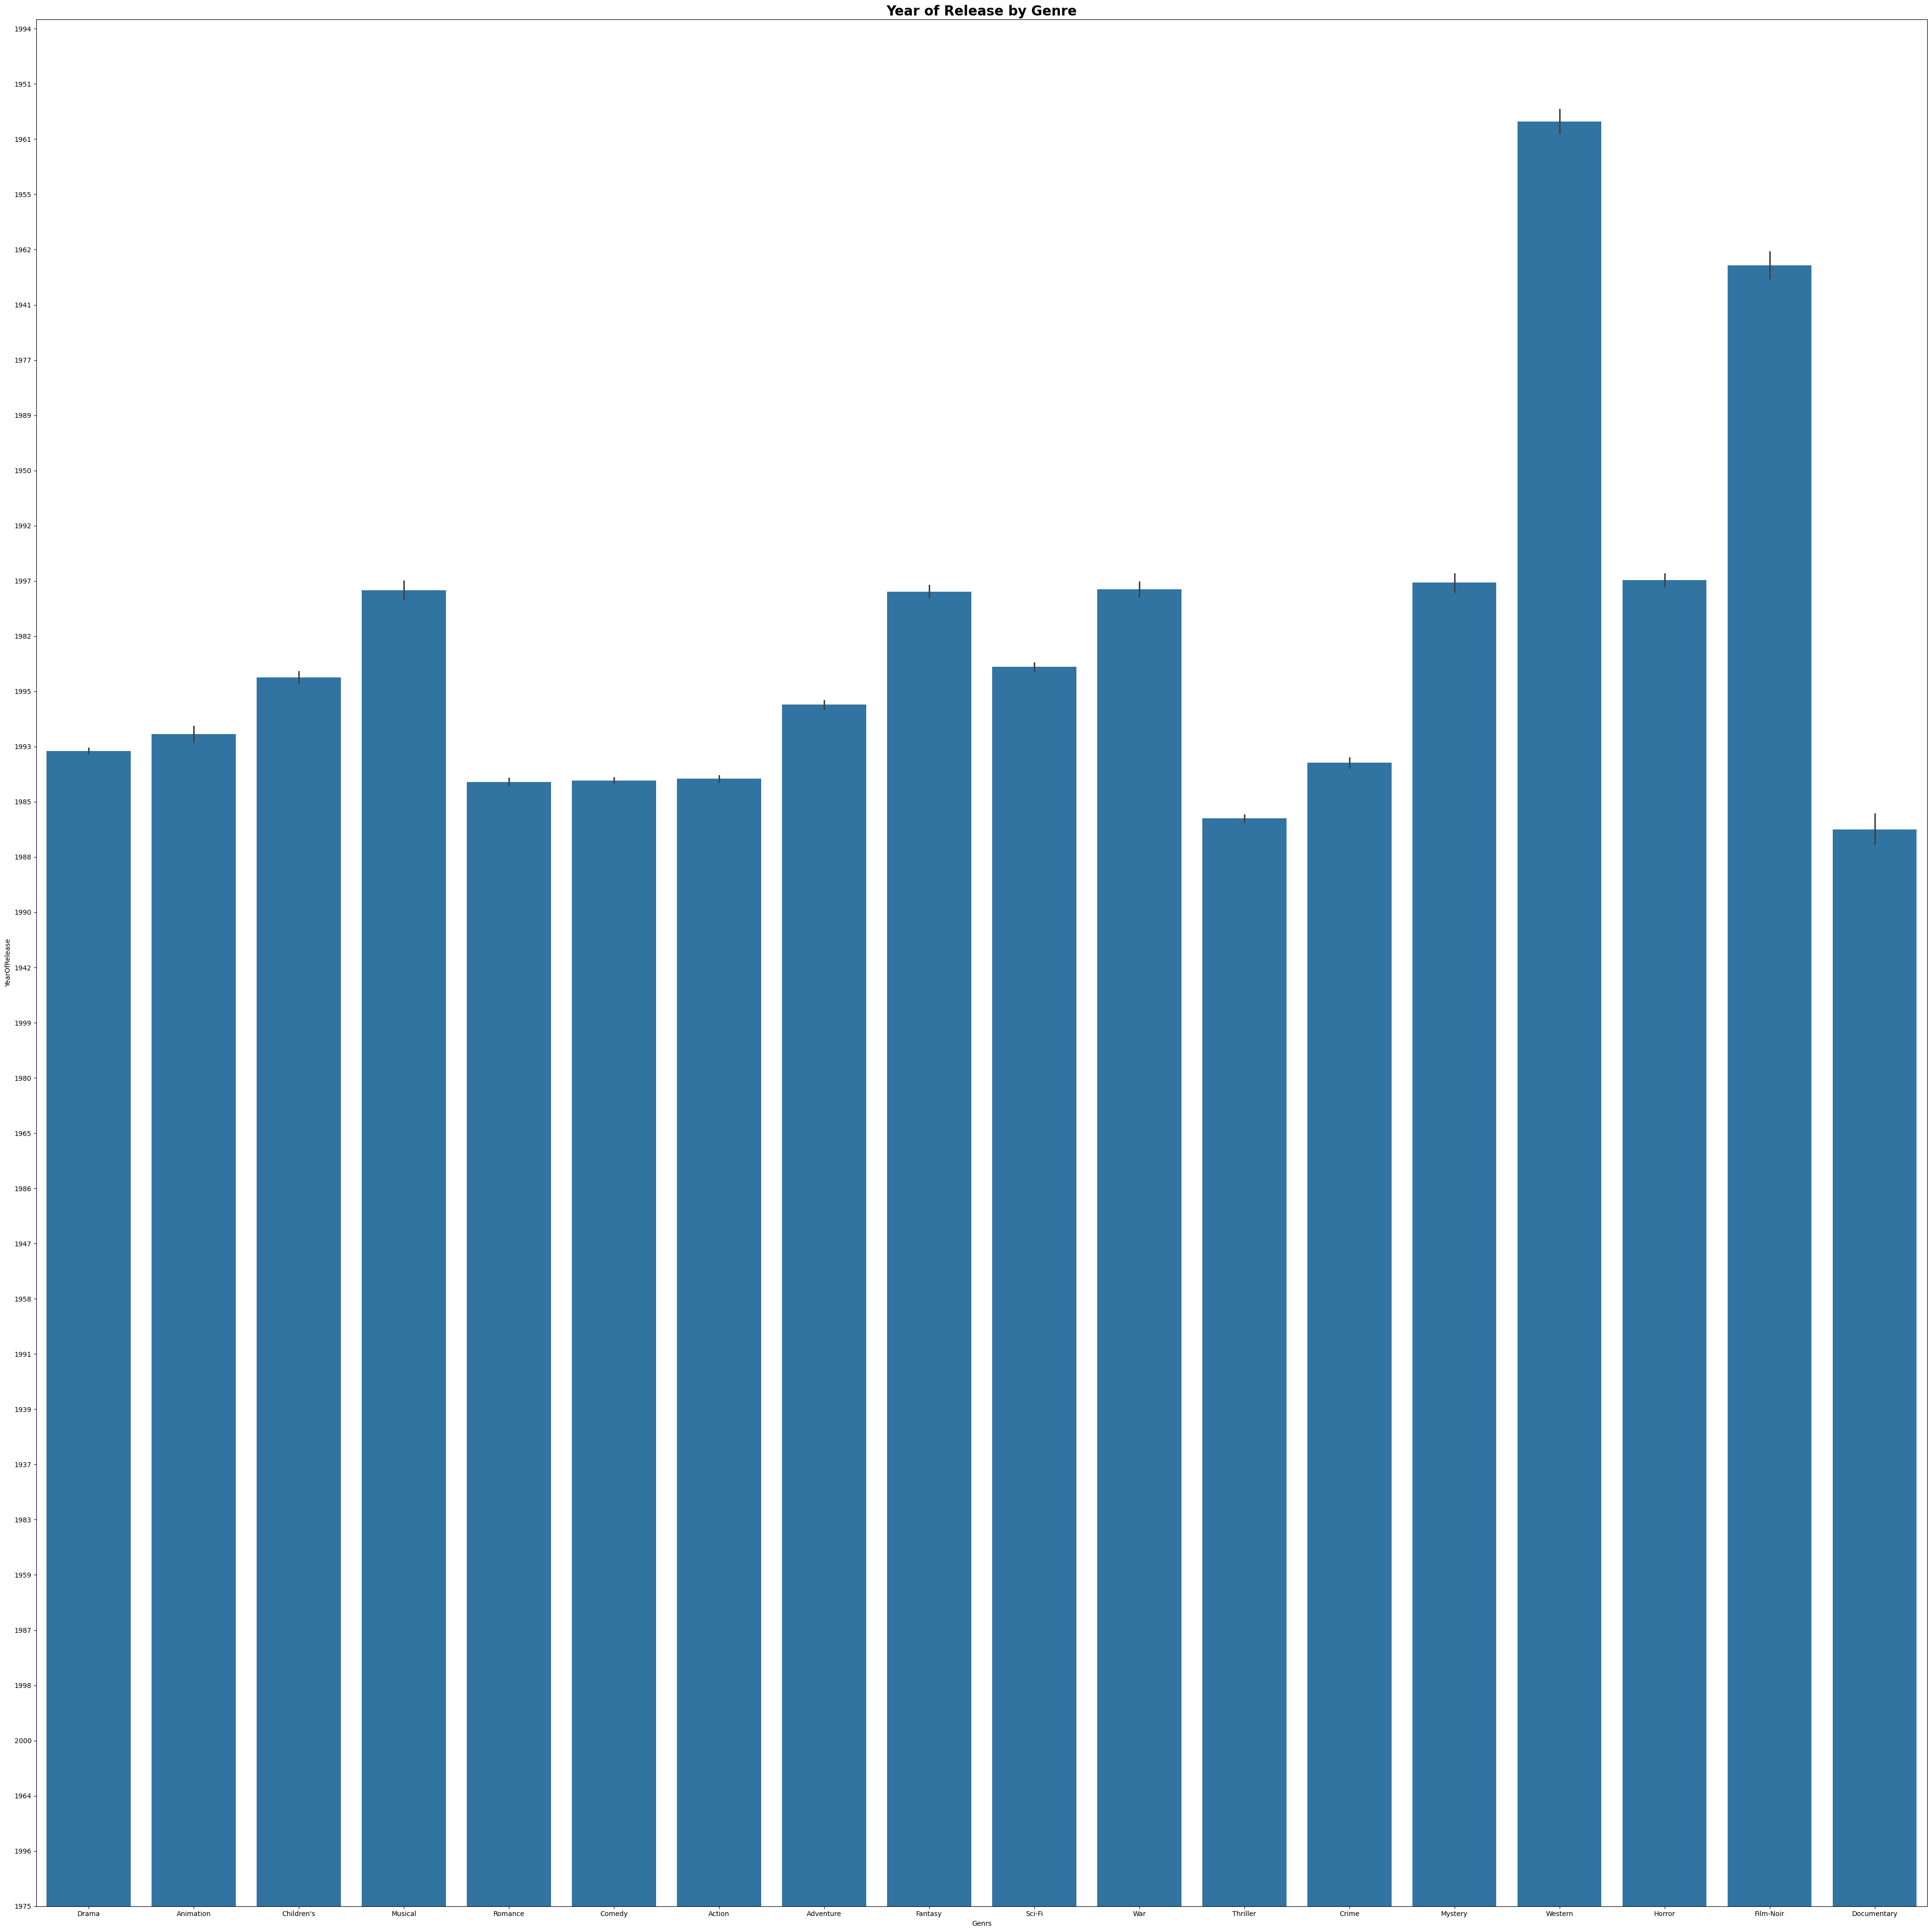

In [32]:


plt.figure(figsize=(40, 40))
sns.barplot(
    
    x='Genrs',  
    y='YearOfRelease',  
    data=favorite_table_exploded,
    
)


plt.title('Year of Release by Genre', fontsize=20, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_25444\543972177.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_ratings = favorite_table_exploded.groupby('YearRange')['Ratings'].mean().reset_index()


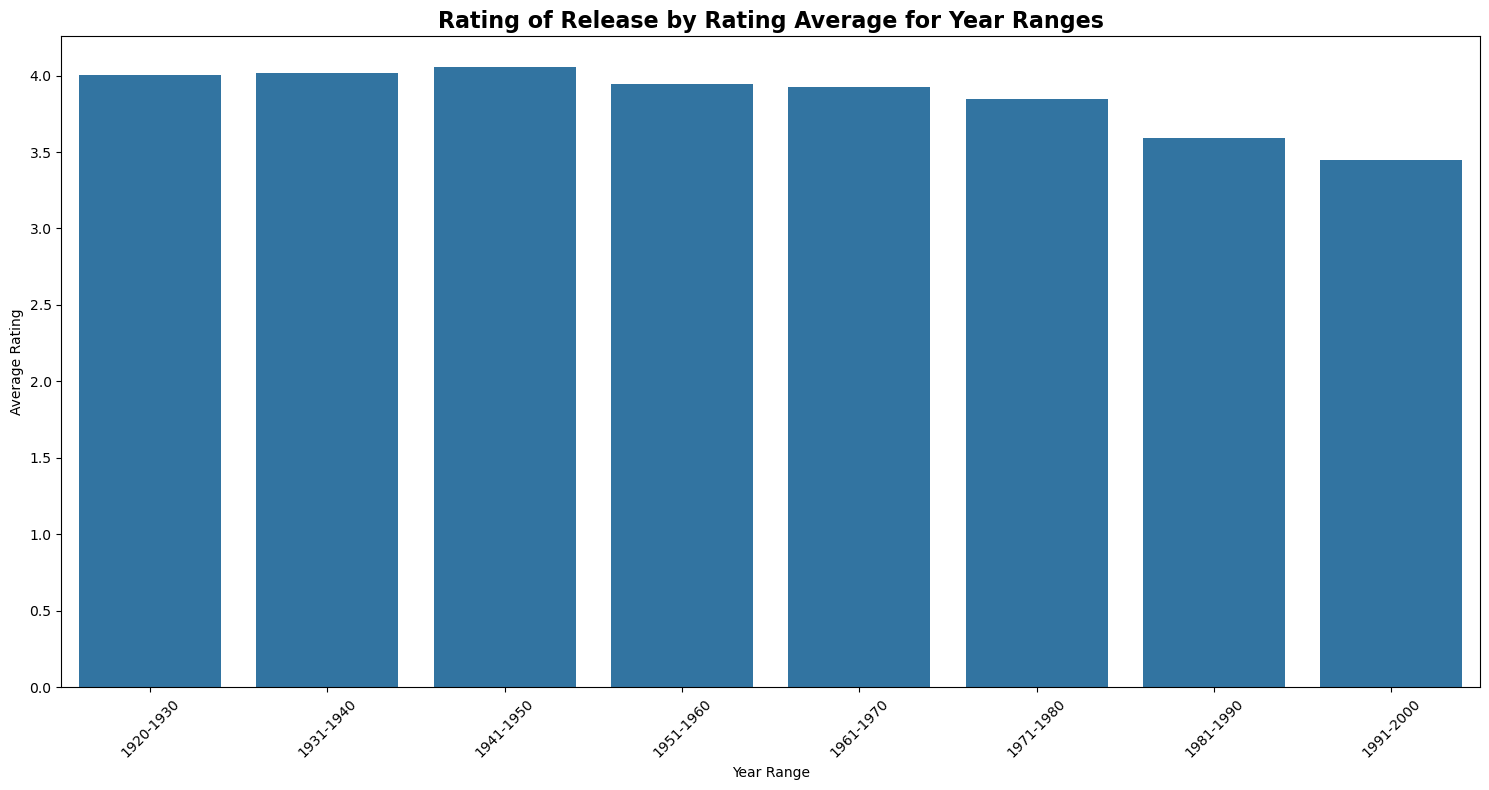

In [33]:
favorite_table_exploded['YearOfRelease'] = pd.to_numeric(favorite_table_exploded['YearOfRelease'], errors='coerce')


year_bins = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000]
year_labels = ['1920-1930', '1931-1940', '1941-1950', '1951-1960', '1961-1970', '1971-1980', '1981-1990', '1991-2000']


favorite_table_exploded['YearRange'] = pd.cut(
    favorite_table_exploded['YearOfRelease'], 
    bins=year_bins, 
    labels=year_labels, 
    right=True  
)


average_ratings = favorite_table_exploded.groupby('YearRange')['Ratings'].mean().reset_index()


plt.figure(figsize=(15, 8))

sns.barplot(
    y='Ratings',  
    x='YearRange',  
    data=average_ratings,  
)


plt.title('Rating of Release by Rating Average for Year Ranges', fontsize=16, fontweight='bold')
plt.xlabel('Year Range')
plt.ylabel('Average Rating')

plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

# Movies encoding

In [34]:
favorit_movies = rating_df[rating_df['Ratings']>=4]
unique_user_ids = favorit_movies['UserIDs'].unique()

print(len(unique_user_ids))


6038


In [35]:
favorit_movies_grouped = favorit_movies.groupby('UserIDs')['MoviesIDs'].apply(list)
favorit_movies_grouped

UserIDs
1       [1193, 3408, 2355, 1287, 2804, 594, 919, 595, ...
2       [1357, 3068, 1537, 2194, 648, 2268, 3468, 1210...
3       [3421, 1394, 104, 2735, 1210, 1079, 1615, 1291...
4       [3468, 2951, 1214, 1036, 260, 2028, 480, 1198,...
5       [2987, 2333, 1175, 2337, 1535, 1392, 866, 2770...
                              ...                        
6036    [589, 3006, 3008, 2064, 2069, 590, 593, 594, 5...
6037    [3006, 2064, 593, 903, 904, 908, 909, 910, 912...
6038    [1419, 3088, 232, 1136, 1148, 1183, 2146, 3548...
6039    [588, 2067, 1416, 3022, 2080, 3035, 3037, 901,...
6040    [573, 589, 2068, 593, 2070, 2076, 903, 904, 90...
Name: MoviesIDs, Length: 6038, dtype: object

In [36]:
favorit_movies_grouped.shape

(6038,)

# Movies Encoding

In [37]:
from mlxtend.preprocessing import TransactionEncoder
from scipy.sparse import csr_matrix

te = TransactionEncoder()
te_matrix = te.fit(favorit_movies_grouped).transform(favorit_movies_grouped, sparse=True)

sparse_matrix_favorite_movies = csr_matrix(te_matrix)

# Display the sparse matrix info
sparse_matrix_favorite_movies.get_shape()

(6038, 3533)

# Apriori

In [38]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [39]:
dense_df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix_favorite_movies, 
                                             columns=te.columns_)

dense_df.columns = [str(col) for col in dense_df.columns]

C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_25444\2141295360.py:1: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  dense_df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix_favorite_movies,


In [68]:
import pickle

In [69]:
def association(data_rating):
    frequent = apriori(data_rating, min_support = 0.07, use_colnames = True)
    frequent['length'] = frequent['itemsets'].apply(lambda x: len(x))
    frequent[(frequent['length'] == 2) & \
             (frequent['support'] >= 0.07)]
    data_rating = association_rules(frequent, metric = "lift", min_threshold = 1)
    data_rating = data_rating[(data_rating['lift'] >= 2) & (data_rating['confidence'] >= 0.7)]
    with open('association_rules.pkl', 'wb') as f:
        pickle.dump(data_rating, f)
    return data_rating

In [70]:
data_rating = association(dense_df)
data_rating

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
267,(25),(296),0.099868,0.293143,0.070553,0.706468,2.409973,0.041278,2.408105,0.649968
270,(25),(608),0.099868,0.343491,0.070884,0.709784,2.066383,0.036581,2.262142,0.573318
343,(32),(2571),0.179364,0.359556,0.132329,0.737765,2.051878,0.067837,2.442256,0.624688
445,(36),(318),0.110798,0.338854,0.082809,0.747384,2.205623,0.045264,2.617200,0.614724
446,(36),(527),0.110798,0.342994,0.078503,0.708520,2.065690,0.040500,2.254035,0.580184
...,...,...,...,...,...,...,...,...,...,...
325631,"(1200, 2571, 1214, 1240, 260)","(1196, 1210)",0.092083,0.271613,0.070884,0.769784,2.834120,0.045873,3.163931,0.712793
325652,"(1214, 1200, 2571, 1210)","(260, 1196, 1240)",0.091090,0.187479,0.070884,0.778182,4.150761,0.053807,3.663003,0.835154
325653,"(1200, 2571, 1210, 1240)","(1196, 1214, 260)",0.093077,0.176052,0.070884,0.761566,4.325809,0.054498,3.455664,0.847734
325655,"(1214, 1200, 1210, 1240)","(2571, 1196, 260)",0.093740,0.211825,0.070884,0.756184,3.569849,0.051028,3.232659,0.794337


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
267,(25),(296),0.099868,0.293143,0.070553,0.706468,2.409973,0.041278,2.408105,0.649968
270,(25),(608),0.099868,0.343491,0.070884,0.709784,2.066383,0.036581,2.262142,0.573318
343,(32),(2571),0.179364,0.359556,0.132329,0.737765,2.051878,0.067837,2.442256,0.624688
445,(36),(318),0.110798,0.338854,0.082809,0.747384,2.205623,0.045264,2.617200,0.614724
446,(36),(527),0.110798,0.342994,0.078503,0.708520,2.065690,0.040500,2.254035,0.580184
...,...,...,...,...,...,...,...,...,...,...
325631,"(1200, 2571, 1214, 1240, 260)","(1196, 1210)",0.092083,0.271613,0.070884,0.769784,2.834120,0.045873,3.163931,0.712793
325652,"(1200, 2571, 1214, 1210)","(1240, 1196, 260)",0.091090,0.187479,0.070884,0.778182,4.150761,0.053807,3.663003,0.835154
325653,"(1200, 2571, 1210, 1240)","(1196, 1214, 260)",0.093077,0.176052,0.070884,0.761566,4.325809,0.054498,3.455664,0.847734
325655,"(1200, 1240, 1214, 1210)","(2571, 1196, 260)",0.093740,0.211825,0.070884,0.756184,3.569849,0.051028,3.232659,0.794337


In [65]:
filtered_data = data_rating[(data_rating['antecedents'].apply(len) ==1) ]
data_analyse = filtered_data.sort_values(by=['lift'],ascending=False)
data_analyse.shape

(1356, 10)

In [43]:
filtered_rows = []

for index, row in data_analyse.iterrows():
    ant = row['antecedents']
    cnsq = row['consequents']
    ant = int(next(iter(ant)))
    cnsq = int(next(iter(cnsq)))

    # Filter the movies_df for matching rows
    matching_rows = movies_df[(movies_df['MovieID'] == ant) | (movies_df['MovieID'] == cnsq)]
    
    # Append the matching rows to the list
    filtered_rows.append(matching_rows)

# Combine all matching rows into a single DataFrame (optional)
result_df = pd.concat(filtered_rows, ignore_index=True)

result_df



,MovieID,Title,Genrs,YearOfRelease
0,745,"Close Shave, A (1995)",Animation|Comedy|Thriller,1995
1,1148,"Wrong Trousers, The (1993)",Animation|Comedy,1993
2,2000,Lethal Weapon (1987),Action|Comedy|Crime|Drama,1987
3,2001,Lethal Weapon 2 (1989),Action|Comedy|Crime|Drama,1989
4,903,Vertigo (1958),Mystery|Thriller,1958
5,904,Rear Window (1954),Mystery|Thriller,1954
6,1374,Star Trek: The Wrath of Khan (1982),Action|Adventure|Sci-Fi,1982
7,1376,Star Trek IV: The Voyage Home (1986),Action|Adventure|Sci-Fi,1986
8,1080,Monty Python's Life of Brian (1979),Comedy,1979
9,1136,Monty Python and the Holy Grail (1974),Comedy,1974


## Replacing with movie titles

In [44]:
movies_names = movies_df.drop(columns=['Genrs','YearOfRelease'])
movies_names.rename(columns={'MovieID':'id','Title':'title'},inplace=True)

movies_names.head()

,id,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [45]:
def get_firs_ele(a,l):
    i=0
    ab=[]
    for ele in a :
       if (len(ele)>l):
           ab.append(ele[0])
           
           
       else:
           ab.append(ele[0])
    return ab 
    

In [46]:
def transform2a_1c(rules_data):
    # unfrozen the dataframe
    a = [list(x) for x in rules_data.antecedents.values]
    print(len(a))
    
    ab= get_firs_ele(a,1)

    c_list = [list(x) for x in rules_data.consequents.values]
    c_df = pd.DataFrame({'consequents': c_list})

    # Use explode to flatten the lists
    c_exploded = c_df['consequents'].explode()
    print(c_exploded.shape)

    r = pd.DataFrame(np.array(ab),
                       columns=['antecedents'])
    print(r)
    c = pd.DataFrame(np.array(c_exploded),
                       columns=['consequents'])
    r['consequents'] = c
    r['antecedent 1'] = pd.DataFrame(r.antecedents.tolist(), index= r.index)
    print(r)
    r[['consequent 1']] = pd.DataFrame(r.consequents.tolist(), index= r.index)
    r.drop(['antecedents','consequents'],inplace=True,axis=1)
    # replace ant1
    
    r['antecedent 1'] = r['antecedent 1'].astype(str)
    movies_names['id'] = movies_names['id'].astype(str)
    r = pd.merge(r, movies_names,  how='left', left_on=['antecedent 1'], 
                             right_on = ['id'])
    r.drop(['id','antecedent 1'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'antecedent 1'})
    # # replace ant2
    # r = pd.merge(r, movies_names,  how='left', left_on=['antecedent 2'], 
    #                          right_on = ['id'])
    # r.drop(['id','antecedent 2'],inplace=True,axis=1)
    # r= r.rename(columns = {'title': 'antecedent 2'})
    # replace con1
    r = pd.merge(r, movies_names,  how='left', left_on=['consequent 1'], 
                             right_on = ['id'])
    r.drop(['id','consequent 1'],inplace=True,axis=1)
    r= r.rename(columns = {'title': 'consequent 1'})
    # add metrics
    lift = rules_data[['lift']].reset_index(drop = True)
    r['lift'] = lift
    confidence = rules_data[['confidence']].reset_index(drop = True)
    r['confidence'] = confidence
    support = rules_data[['support']].reset_index(drop = True)
    r['support'] = support
    # sort
    r = r.sort_values(by=['lift'],ascending=False)
    r
    return r

In [47]:
transform2a_1c(data_rating)

45759
(56380,)
      antecedents
0              25
1              25
2              32
3              36
4              36
...           ...
45754        1200
45755        1214
45756        1200
45757        1214
45758        1214

[45759 rows x 1 columns]
      antecedents consequents antecedent 1
0              25         296           25
1              25         608           25
2              32        2571           32
3              36         318           36
4              36         527           36
...           ...         ...          ...
45754        1200        1200         1200
45755        1214        1200         1214
45756        1200        1240         1200
45757        1214         589         1214
45758        1214        1240         1214

[45759 rows x 3 columns]


,antecedent 1,consequent 1,lift,confidence,support
55,"Close Shave, A (1995)","Wrong Trousers, The (1993)",6.203903,0.841503,0.085293
32451,"Godfather: Part II, The (1974)",Indiana Jones and the Last Crusade (1989),5.604402,0.711921,0.071216
44142,Star Wars: Episode V - The Empire Strikes Back...,Star Wars: Episode V - The Empire Strikes Back...,5.412424,0.735043,0.071216
32450,"Godfather: Part II, The (1974)",Star Wars: Episode IV - A New Hope (1977),5.370197,0.802239,0.071216
44145,Indiana Jones and the Last Crusade (1989),Raiders of the Lost Ark (1981),5.250860,0.713101,0.071216
...,...,...,...,...,...
983,Good Will Hunting (1997),"Silence of the Lambs, The (1991)",2.000052,0.745962,0.084134
2469,Alien (1979),"Godfather, The (1972)",2.000050,0.748611,0.089268
1297,"Blues Brothers, The (1980)",Alien (1979),2.000029,0.868512,0.083140
5609,"Usual Suspects, The (1995)",Pulp Fiction (1994),2.000026,0.831412,0.095561


# Eclat

In [73]:
dense_df.head(2)

,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
eclate_df = dense_df.astype(pd.SparseDtype("int", fill_value=0))

# Summing the values
items_total =eclate_df.sum(axis=0)
items_total

1       1655
2        285
3        148
4         37
5         96
        ... 
3948     530
3949     240
3950      33
3951      27
3952     264
Length: 3533, dtype: Sparse[int32, 0]

In [77]:
items_per_transaction = eclate_df.sum(axis=1)
items_per_transaction

0        45
1        73
2        37
3        18
4        82
       ... 
6033    399
6034    120
6035     13
6036     90
6037    213
Length: 6038, dtype: Sparse[int32, 0]

In [78]:
from mlxtend.frequent_patterns import apriori, association_rules 

minsup = 0.1
df_frequent_itemsets = apriori(eclate_df, min_support = minsup, use_colnames = True)

c:\Users\WINDOWS\anaconda3\envs\tensorflowEnv\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [79]:
df_frequent_itemsets

,support,itemsets
0,0.274097,(1)
1,0.107983,(6)
2,0.115601,(11)
3,0.104670,(17)
4,0.130341,(21)
...,...,...
3724,0.107320,"(1270, 1196, 1210, 2571, 260)"
3725,0.104174,"(1196, 1210, 2028, 2571, 260)"
3726,0.104008,"(1196, 2571, 1214, 1240, 260)"
3727,0.100364,"(1196, 1210, 1198, 1240, 589)"


In [80]:
path = 'eclat_combinations_01.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df_frequent_itemsets.to_csv(f)

In [81]:
df_rules = association_rules(df_frequent_itemsets, metric = 'support', min_threshold = 0.05, support_only = True)

In [85]:
eclat_rules_005 = df_rules[['antecedents', 'consequents', 'support']]
eclat_rules_005.sort_values(by=['support'],ascending=False)

,antecedents,consequents,support
402,(1196),(260),0.324611
403,(260),(1196),0.324611
406,(1198),(260),0.276085
407,(260),(1198),0.276085
1778,(1196),(1210),0.271613
...,...,...,...
20305,"(1196, 1210, 260)","(1200, 1240)",0.100033
20304,"(1196, 1210, 1240)","(1200, 260)",0.100033
20303,"(1200, 1196, 1210)","(260, 1240)",0.100033
20302,"(260, 1200, 1210, 1240)",(1196),0.100033
